# Q.4 Understanding training parameters

In Q.4 , we have to repeat the experiments in 3a and 3b . So, we will use the same dataset as in Q.3

In [2]:
#All imports

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

In [3]:
# Generating data
x = np.random.uniform(0,1,100)
y = np.sin(2*np.pi*x)
gaussian_noise = np.random.normal(0,0.1,100)
y_noised = y + gaussian_noise
df = pd.DataFrame({'x':x, 'y':y_noised})
print(df)

#Obtain train and test splits
train_df = df.iloc[::2].reset_index(drop=True)
test_df = df.iloc[1::2].reset_index(drop=True)
print(train_df)
print(test_df)

X_train = train_df['x']
Y_train = train_df['y']
X_test = test_df['x']
Y_test = test_df['y']

#Feature Scaling
mean = np.mean(X_train)
std = np.std(X_train)
if std == 0:
  std = 1e-8
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

           x         y
0   0.771437 -1.010940
1   0.616476 -0.733113
2   0.888877 -0.709281
3   0.070705  0.304141
4   0.764585 -1.116695
..       ...       ...
95  0.481495  0.105578
96  0.823588 -0.923004
97  0.354262  0.768656
98  0.333218  0.929175
99  0.508963 -0.172317

[100 rows x 2 columns]
           x         y
0   0.771437 -1.010940
1   0.888877 -0.709281
2   0.764585 -1.116695
3   0.270904  0.899620
4   0.766749 -1.096675
5   0.435056  0.458271
6   0.389044  0.540333
7   0.687604 -1.055964
8   0.441161  0.513281
9   0.796859 -1.157691
10  0.465823  0.180112
11  0.535170 -0.267736
12  0.399879  0.678029
13  0.582664 -0.487337
14  0.093911  0.511408
15  0.963368 -0.358770
16  0.427458  0.375935
17  0.120601  0.736757
18  0.970715 -0.156879
19  0.753113 -1.082090
20  0.963721 -0.285723
21  0.427034  0.503820
22  0.197964  1.141489
23  0.822879 -0.970606
24  0.965775 -0.135007
25  0.112590  0.687323
26  0.432091  0.372006
27  0.658842 -0.807871
28  0.545195 -0.503139
29  0.8639

In [4]:
def apply_kernel(X,kernelType, M, centers = None):
    if kernelType=='polynomial':
      features = np.zeros((len(X),M+1))
      for i in range(M+1):
        features[:,i] = X**i
      return features


    if centers is None:
       centers = np.linspace(np.min(X),np.max(X),M)

    if kernelType=='gaussian':
      if M==0:
        return np.ones((len(X),1))
      sigma = 1/M * 2.0
      features = np.zeros((len(X),M))
      for j in range(M):
        mu_j = centers[j]
        features[:,j] = np.exp(-(X-mu_j)**2/(2 * sigma**2))
      features = np.hstack([np.ones((len(X),1)),features])
      return features

    if kernelType == 'sigmoidal':
      if(M ==0):
        return np.ones((len(X),1))
      features = np.zeros((len(X),M))
      a = 5
      for j in range(M):
        a_j = centers[j]
        features[:,j] = 1/(1+np.exp(-a*(X-a_j)))
      features = np.hstack([np.ones((len(X),1)),features])
      return features


def KernelRegressionPred_Error(w_est, X_train, Y_train, X_test, Y_test, kernelType):
  M = len(w_est) - 1

  X_tr = apply_kernel(X_train, kernelType, M)
  X_te = apply_kernel(X_test, kernelType, M)

  Y_tr_pred = X_tr @ w_est
  Y_te_pred = X_te @ w_est

  RMSE_tr = np.sqrt(np.mean((Y_tr_pred - Y_train)**2))
  RMSE_te = np.sqrt(np.mean((Y_te_pred - Y_test)**2))

  return RMSE_tr, RMSE_te

def closed_form_solution(X_train, Y_train, kernelType, M, lamda = 0):
  X = apply_kernel(X_train, kernelType, M)
  I = np.eye(X.shape[1])
  if lamda == 0:
    w_opt = np.linalg.pinv(X.T @ X) @ X.T @ Y_train
  else:
    w_opt = np.linalg.pinv(X.T @ X + lamda*I) @ X.T @ Y_train
  return w_opt

def Pred(w_est,X_train,Y_train,Xtest,Y_test,kernelType):
  M = len(w_est) - 1
  X_tr = apply_kernel(X_train, kernelType, M)
  X_te = apply_kernel(X_test, kernelType, M)
  Y_tr_pred = X_tr @ w_est
  Y_te_pred = X_te @ w_est
  return Y_tr_pred, Y_te_pred

In [5]:
def training(X_train, Y_train, X_test, Y_test, kernelType, M, epochs, stepSize, BatchSize=1,print_epochs = True,plot_= True,return_err = False):
    total_training_data = len(X_train)
    n_features = M + 1
    weights = np.zeros(n_features)
    best_weights = weights.copy()

    centers = np.linspace(np.min(X_train), np.max(X_train), M)

    train_error = []
    test_error = []
    best_test_error = float('inf')
    best_epoch = 0

    batches_per_epoch = int(np.ceil(total_training_data / BatchSize))

    for epoch in range(epochs):
        tr_err, te_err = KernelRegressionPred_Error(weights, X_train, Y_train, X_test, Y_test, kernelType)
        train_error.append(tr_err)
        test_error.append(te_err)

        if te_err < best_test_error:
            best_test_error = te_err
            best_weights = weights.copy()
            best_epoch = epoch

        indices = np.random.permutation(total_training_data)
        X_shuffled = X_train.to_numpy()[indices]
        Y_shuffled = Y_train.to_numpy()[indices]

        for i in range(batches_per_epoch):
            start = i * BatchSize
            end = min(start + BatchSize, total_training_data)

            X_batch = X_shuffled[start:end]
            Y_batch = Y_shuffled[start:end]

            gradient = np.zeros(n_features)

            for j in range(len(X_batch)):
                x = X_batch[j]
                y_true = Y_batch[j]

                X_tr = apply_kernel(np.array([x]), kernelType, M, centers)[0]

                X_pred = np.dot(weights, X_tr)
                error = X_pred - y_true
                gradient += error * X_tr

            gradient_avg = gradient / len(X_batch)
            weights -= stepSize * gradient_avg

        if print_epochs and (epoch % max(1, epochs // 10) == 0):
            grad_norm = np.linalg.norm(gradient_avg)
            print(f"Epoch {epoch}/{epochs}: "
                  f"Train MSE={tr_err:.4f}, Test MSE={te_err:.4f}, "
                  f"|∇|={grad_norm:.6f}")

    # Evaluate final errors
    tr_err, te_err = KernelRegressionPred_Error(weights, X_train, Y_train, X_test, Y_test, kernelType)
    train_error.append(tr_err)
    test_error.append(te_err)

    if plot_:
      # Plot MSE over epochs
      plt.figure(figsize=(12, 6))
      epochs_range = np.arange(len(train_error))

      plt.semilogy(epochs_range, train_error, 'b-', label='Training MSE', alpha=0.7)
      plt.semilogy(epochs_range, test_error, 'r-', label='Testing MSE', alpha=0.7)

      # Mark minimum test error
      min_idx = np.argmin(test_error)
      min_value = test_error[min_idx]
      plt.scatter(min_idx, min_value, s=100, c='red', zorder=5,
                label=f'Min Test Error: {min_value:.4f}')

      # Closed-form solution
      w_closed = closed_form_solution(X_train, Y_train, kernelType, M)
      _, cf_test_err = KernelRegressionPred_Error(w_closed, X_train, Y_train, X_test, Y_test, kernelType)

      plt.axhline(y=cf_test_err, color='g', linestyle='--',
                label=f'Closed-Form MSE: {cf_test_err:.4f}')

      plt.title(f'{kernelType.capitalize()} Kernel (M={M}, η={stepSize}, Batch={BatchSize})\n'
              f'Best: {best_test_error:.4f} | Final: {te_err:.4f} | Closed: {cf_test_err:.4f}')
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error (log scale)')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

      # Weight comparison
      print("\nWeight Comparison:")
      print(f"{'':<15} {'SGD Weights':<25} {'Closed-Form Weights':<25} {'Difference':<15}")
      for i, (w_sgd, w_cf) in enumerate(zip(best_weights, w_closed)):
          diff = abs(w_sgd - w_cf)
          print(f"w{i}: {w_sgd:12.6f} | {w_cf:12.6f} | {diff:12.6f}")

    if return_err:
      return best_weights, train_error, test_error
    else:
      return best_weights

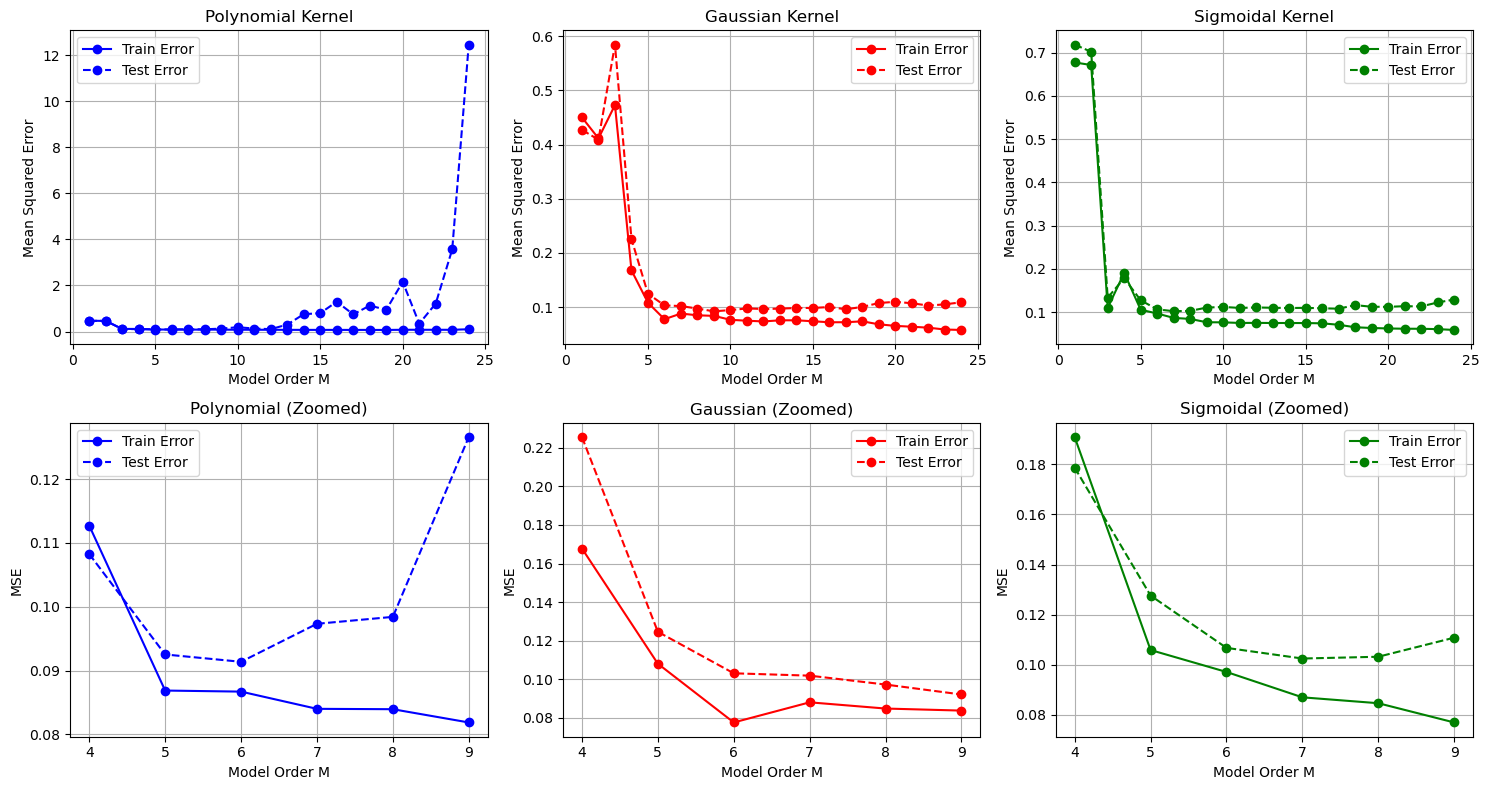

In [6]:
M_range=list(range(1,25))

polynomial_tr_error = []
polynomial_te_error = []
gaussian_tr_error = []
gaussian_te_error = []
sigmoid_tr_error = []
sigmoid_te_error = []

for m in  M_range:
  w_polynomial = closed_form_solution(X_train,Y_train,'polynomial',m,0)
  tr_err, te_err = KernelRegressionPred_Error(w_polynomial,X_train,Y_train,X_test,Y_test,'polynomial')
  polynomial_tr_error.append(tr_err)
  polynomial_te_error.append(te_err)

  w_gaussian = closed_form_solution(X_train,Y_train,'gaussian',m,0)
  tr_err, te_err = KernelRegressionPred_Error(w_gaussian,X_train,Y_train,X_test,Y_test,'gaussian')
  gaussian_tr_error.append(tr_err)
  gaussian_te_error.append(te_err)

  w_sigmoidal= closed_form_solution(X_train,Y_train,'sigmoidal',m,0)
  tr_err, te_err = KernelRegressionPred_Error(w_sigmoidal,X_train,Y_train,X_test,Y_test,'sigmoidal')
  sigmoid_tr_error.append(tr_err)
  sigmoid_te_error.append(te_err)


fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

# ---------- Full Range Plots (Row 0) ----------
# Polynomial
axes[0, 0].plot(M_range, polynomial_tr_error, 'b-o', label='Train Error')
axes[0, 0].plot(M_range, polynomial_te_error, 'b--o', label='Test Error')
axes[0, 0].set_title('Polynomial Kernel')
axes[0, 0].set_xlabel('Model Order M')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Gaussian
axes[0, 1].plot(M_range, gaussian_tr_error, 'r-o', label='Train Error')
axes[0, 1].plot(M_range, gaussian_te_error, 'r--o', label='Test Error')
axes[0, 1].set_title('Gaussian Kernel')
axes[0, 1].set_xlabel('Model Order M')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Sigmoidal
axes[0, 2].plot(M_range, sigmoid_tr_error, 'g-o', label='Train Error')
axes[0, 2].plot(M_range, sigmoid_te_error, 'g--o', label='Test Error')
axes[0, 2].set_title('Sigmoidal Kernel')
axes[0, 2].set_xlabel('Model Order M')
axes[0, 2].set_ylabel('Mean Squared Error')
axes[0, 2].legend()
axes[0, 2].grid(True)

# ---------- Zoomed-In Plots (Row 1, M = 2 to 5) ----------
zoom_range = list(range(4, 10))  # M = 2 to 5
zoom_idx = [M_range.index(m) for m in zoom_range]

# Polynomial zoom
axes[1, 0].plot(zoom_range, [polynomial_tr_error[i] for i in zoom_idx], 'b-o', label='Train Error')
axes[1, 0].plot(zoom_range, [polynomial_te_error[i] for i in zoom_idx], 'b--o', label='Test Error')
axes[1, 0].set_title('Polynomial (Zoomed)')
axes[1, 0].set_xlabel('Model Order M')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Gaussian zoom
axes[1, 1].plot(zoom_range, [gaussian_tr_error[i] for i in zoom_idx], 'r-o', label='Train Error')
axes[1, 1].plot(zoom_range, [gaussian_te_error[i] for i in zoom_idx], 'r--o', label='Test Error')
axes[1, 1].set_title('Gaussian (Zoomed)')
axes[1, 1].set_xlabel('Model Order M')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Sigmoidal zoom
axes[1, 2].plot(zoom_range, [sigmoid_tr_error[i] for i in zoom_idx], 'g-o', label='Train Error')
axes[1, 2].plot(zoom_range, [sigmoid_te_error[i] for i in zoom_idx], 'g--o', label='Test Error')
axes[1, 2].set_title('Sigmoidal (Zoomed)')
axes[1, 2].set_xlabel('Model Order M')
axes[1, 2].set_ylabel('MSE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

Epoch 0/5000: Train MSE=0.7205, Test MSE=0.6989, |∇|=1.691106
Epoch 500/5000: Train MSE=0.1812, Test MSE=0.1942, |∇|=0.270025
Epoch 1000/5000: Train MSE=0.1296, Test MSE=0.1071, |∇|=0.097539
Epoch 1500/5000: Train MSE=0.1112, Test MSE=0.0864, |∇|=0.013527
Epoch 2000/5000: Train MSE=0.0969, Test MSE=0.0860, |∇|=0.025927
Epoch 2500/5000: Train MSE=0.0947, Test MSE=0.0925, |∇|=0.555278
Epoch 3000/5000: Train MSE=0.0917, Test MSE=0.0903, |∇|=0.089580
Epoch 3500/5000: Train MSE=0.0900, Test MSE=0.0917, |∇|=0.032331
Epoch 4000/5000: Train MSE=0.0873, Test MSE=0.0895, |∇|=0.032786
Epoch 4500/5000: Train MSE=0.0874, Test MSE=0.0908, |∇|=0.285842


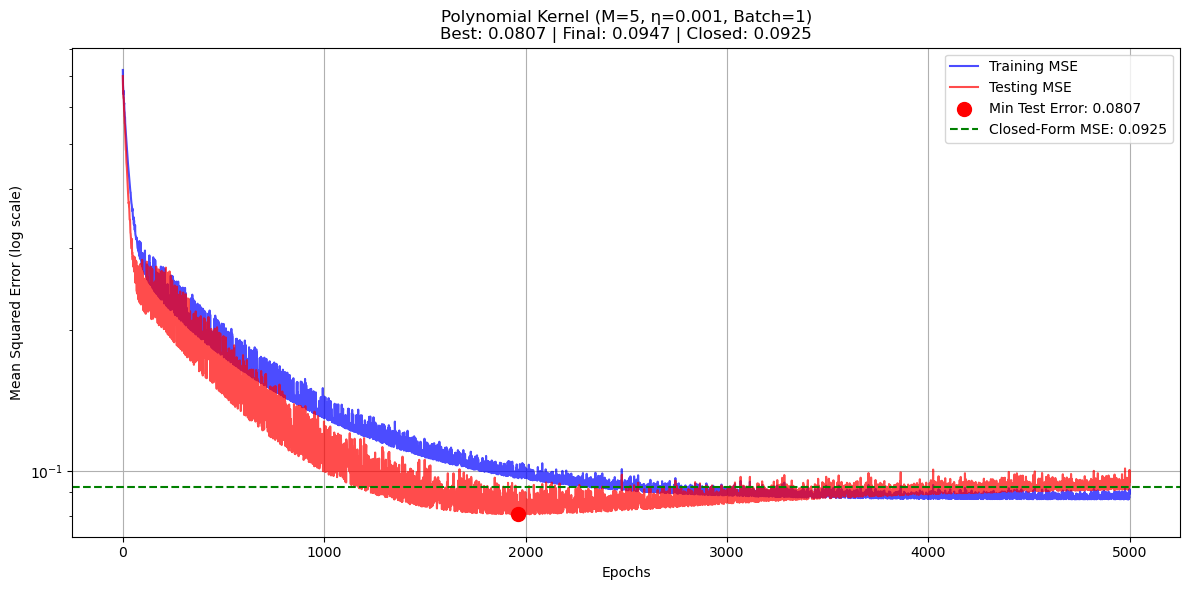


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.499585 |    -0.560890 |     0.061305
w1:    -1.512220 |    -1.616228 |     0.104008
w2:     0.651696 |     0.871177 |     0.219481
w3:     0.701301 |     0.873638 |     0.172337
w4:    -0.084795 |    -0.190910 |     0.106115
w5:    -0.059659 |    -0.124760 |     0.065101
Epoch 0/5000: Train MSE=0.7205, Test MSE=0.6989, |∇|=0.011254
Epoch 500/5000: Train MSE=0.1777, Test MSE=0.1389, |∇|=0.872560
Epoch 1000/5000: Train MSE=0.1608, Test MSE=0.1602, |∇|=0.325333
Epoch 1500/5000: Train MSE=0.1266, Test MSE=0.1259, |∇|=0.704594
Epoch 2000/5000: Train MSE=0.1008, Test MSE=0.0917, |∇|=0.163044
Epoch 2500/5000: Train MSE=0.1001, Test MSE=0.0977, |∇|=1.460800
Epoch 3000/5000: Train MSE=0.0968, Test MSE=0.1083, |∇|=0.041847
Epoch 3500/5000: Train MSE=0.0959, Test MSE=0.1114, |∇|=0.084569
Epoch 4000/5000: Train MSE=0.1494, Test MSE=0.1851, |∇|=0.435753
Epoch 4500/5000: Train MSE=0.1070

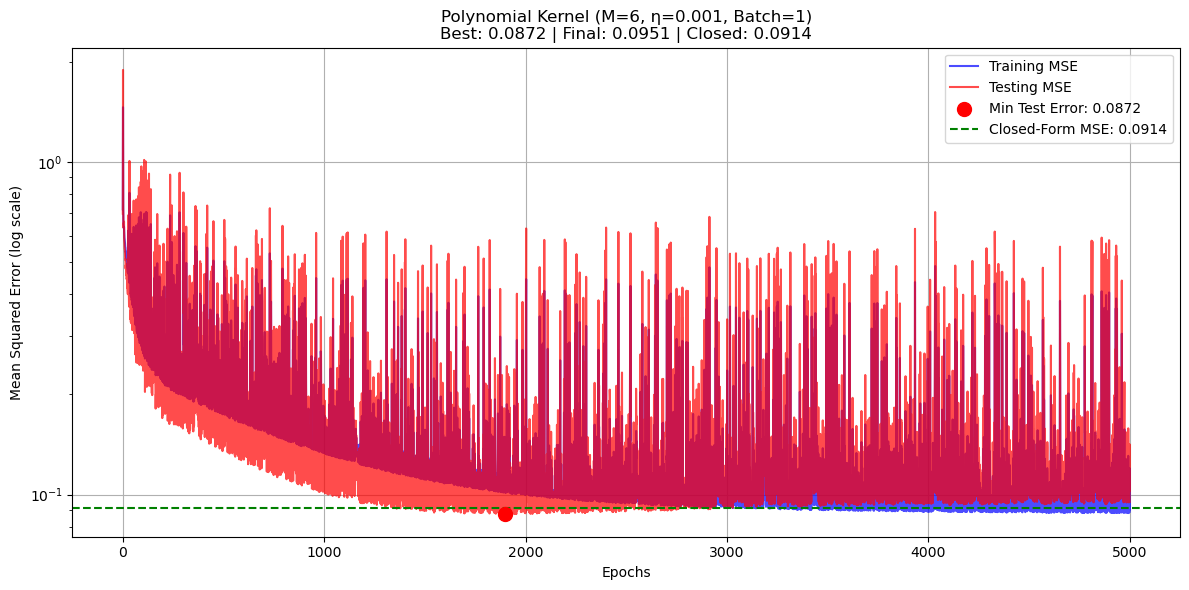


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.520689 |    -0.556576 |     0.035887
w1:    -1.411399 |    -1.635043 |     0.223644
w2:     0.800813 |     0.841958 |     0.041145
w3:     0.485769 |     0.916603 |     0.430834
w4:    -0.243536 |    -0.156761 |     0.086775
w5:     0.024819 |    -0.142512 |     0.167330
w6:     0.049162 |    -0.011175 |     0.060337
Epoch 0/6000: Train MSE=0.7205, Test MSE=0.6989, |∇|=1.835180
Epoch 600/6000: Train MSE=0.3550, Test MSE=0.3132, |∇|=9.556295
Epoch 1200/6000: Train MSE=0.2873, Test MSE=0.2348, |∇|=0.311930
Epoch 1800/6000: Train MSE=0.2339, Test MSE=0.1949, |∇|=0.297401
Epoch 2400/6000: Train MSE=0.1873, Test MSE=0.1425, |∇|=0.358252
Epoch 3000/6000: Train MSE=0.1651, Test MSE=0.1331, |∇|=0.223421
Epoch 3600/6000: Train MSE=0.1490, Test MSE=0.1291, |∇|=0.159454
Epoch 4200/6000: Train MSE=0.1365, Test MSE=0.1123, |∇|=0.165018
Epoch 4800/6000: Train MSE=0.1283, Test MSE=0.1238,

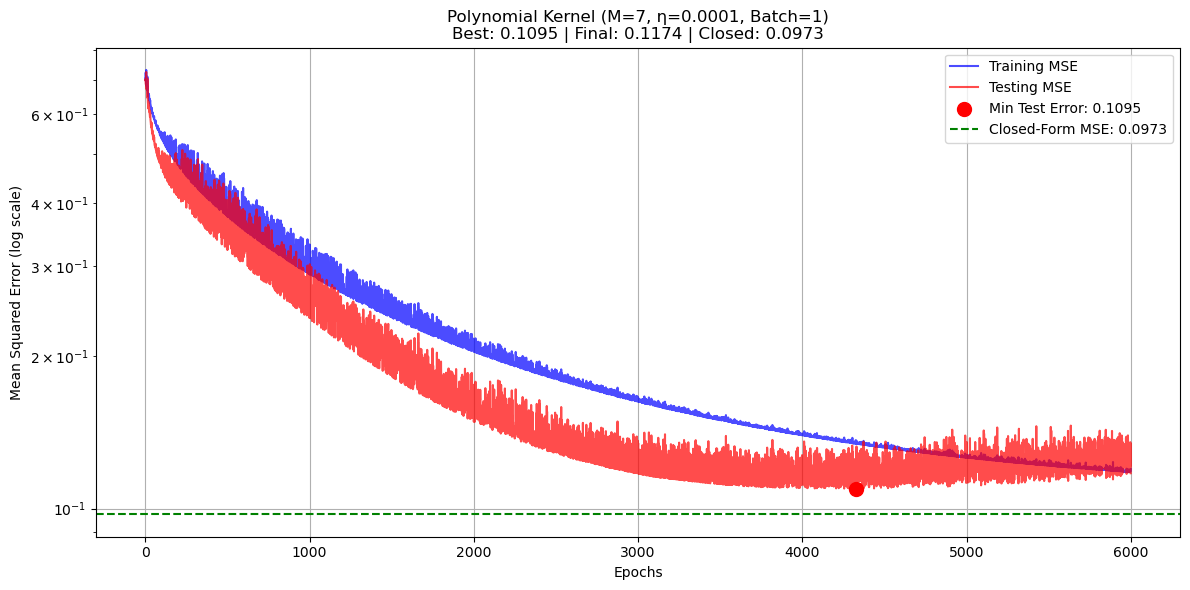


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.426571 |    -0.528002 |     0.101431
w1:    -1.133403 |    -1.596974 |     0.463571
w2:     0.363226 |     0.607975 |     0.244748
w3:    -0.117890 |     0.760259 |     0.878149
w4:     0.165200 |     0.160446 |     0.004753
w5:     0.411051 |     0.024390 |     0.386660
w6:    -0.055428 |    -0.116779 |     0.061351
w7:    -0.077296 |    -0.053327 |     0.023969


In [7]:
#For polynomial kernel

w5= training(X_train, Y_train, X_test, Y_test, 'polynomial', 5, 5000, 0.001, BatchSize=1)
w6 = training(X_train, Y_train,X_test,Y_test,'polynomial',6,5000,0.001,BatchSize=1)
w7 = training(X_train, Y_train,X_test,Y_test,'polynomial',7,6000,0.0001,BatchSize=1)

Epoch 0/4000: Train MSE=0.7205, Test MSE=0.6989, |∇|=1.505280
Epoch 400/4000: Train MSE=0.1170, Test MSE=0.1195, |∇|=0.198991
Epoch 800/4000: Train MSE=0.1103, Test MSE=0.1134, |∇|=0.258637
Epoch 1200/4000: Train MSE=0.1096, Test MSE=0.1125, |∇|=0.201036
Epoch 1600/4000: Train MSE=0.1095, Test MSE=0.1125, |∇|=0.044134
Epoch 2000/4000: Train MSE=0.1095, Test MSE=0.1125, |∇|=0.195850
Epoch 2400/4000: Train MSE=0.1095, Test MSE=0.1125, |∇|=0.005929
Epoch 2800/4000: Train MSE=0.1095, Test MSE=0.1125, |∇|=0.102276
Epoch 3200/4000: Train MSE=0.1095, Test MSE=0.1126, |∇|=0.017325
Epoch 3600/4000: Train MSE=0.1095, Test MSE=0.1126, |∇|=0.016969


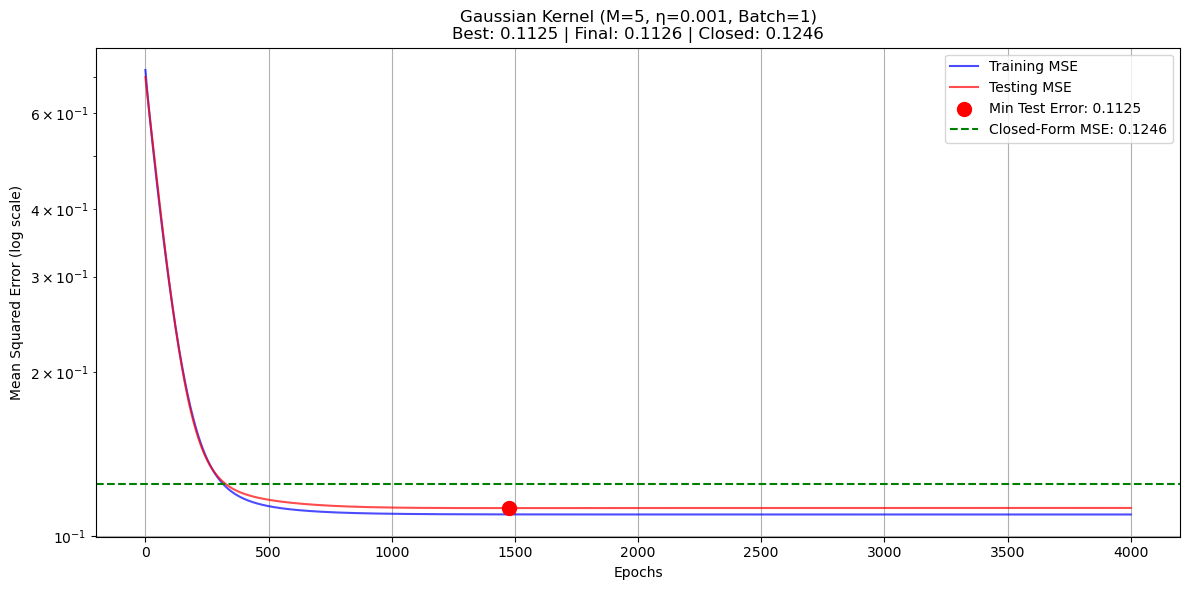


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.010485 |     1.354080 |     1.343595
w1:     0.151989 |    -1.045320 |     1.197309
w2:     1.089710 |    -0.007888 |     1.097599
w3:     0.011775 |    -1.127377 |     1.139152
w4:    -1.150526 |    -2.248473 |     1.097947
w5:    -0.118742 |    -1.315880 |     1.197138
Epoch 0/4000: Train MSE=0.7205, Test MSE=0.6989, |∇|=0.972339
Epoch 400/4000: Train MSE=0.0895, Test MSE=0.1214, |∇|=0.152680
Epoch 800/4000: Train MSE=0.0800, Test MSE=0.1100, |∇|=0.158813
Epoch 1200/4000: Train MSE=0.0782, Test MSE=0.1057, |∇|=0.050723
Epoch 1600/4000: Train MSE=0.0778, Test MSE=0.1040, |∇|=0.075351
Epoch 2000/4000: Train MSE=0.0776, Test MSE=0.1033, |∇|=0.120506
Epoch 2400/4000: Train MSE=0.0776, Test MSE=0.1029, |∇|=0.048989
Epoch 2800/4000: Train MSE=0.0776, Test MSE=0.1028, |∇|=0.154870
Epoch 3200/4000: Train MSE=0.0776, Test MSE=0.1027, |∇|=0.048304
Epoch 3600/4000: Train MSE=0.0776,

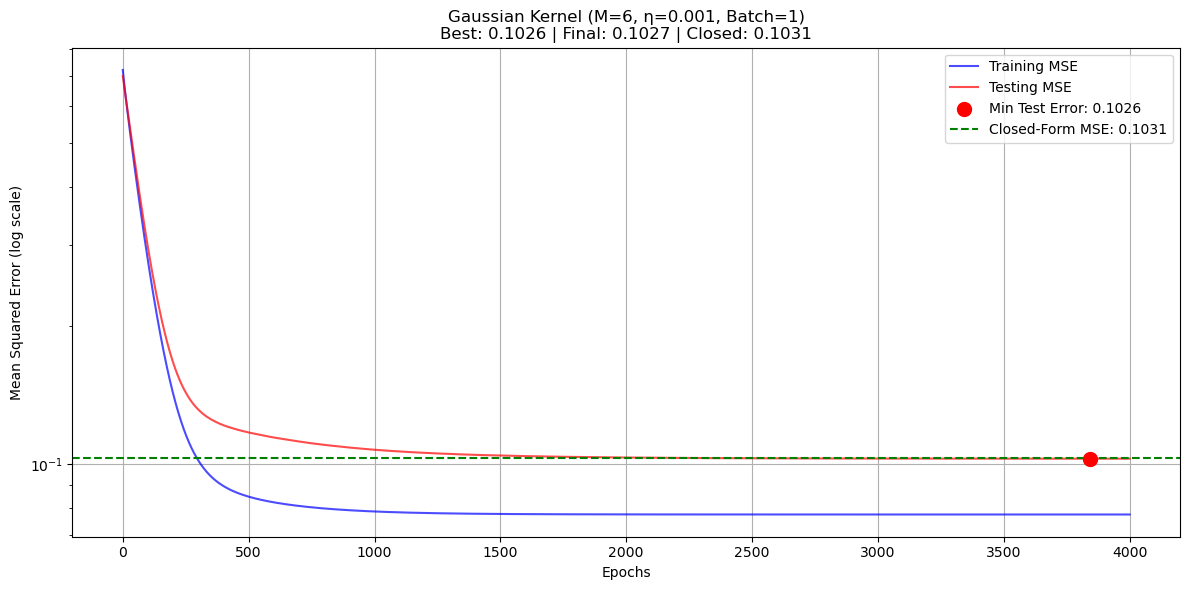


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.007771 |    -0.063657 |     0.055885
w1:     0.076312 |     0.124005 |     0.047693
w2:     1.009956 |     1.054354 |     0.044398
w3:     0.524217 |     0.568575 |     0.044358
w4:    -0.563610 |    -0.518295 |     0.045315
w5:    -1.001376 |    -0.957854 |     0.043521
w6:    -0.056263 |    -0.007528 |     0.048735
Epoch 0/4000: Train MSE=0.7205, Test MSE=0.6989, |∇|=1.452602
Epoch 400/4000: Train MSE=0.0988, Test MSE=0.1169, |∇|=0.195686
Epoch 800/4000: Train MSE=0.0903, Test MSE=0.1067, |∇|=0.061616
Epoch 1200/4000: Train MSE=0.0888, Test MSE=0.1025, |∇|=0.191987
Epoch 1600/4000: Train MSE=0.0884, Test MSE=0.1005, |∇|=0.055824
Epoch 2000/4000: Train MSE=0.0883, Test MSE=0.0995, |∇|=0.088882
Epoch 2400/4000: Train MSE=0.0882, Test MSE=0.0989, |∇|=0.075535
Epoch 2800/4000: Train MSE=0.0882, Test MSE=0.0986, |∇|=0.010081
Epoch 3200/4000: Train MSE=0.0882, Test MSE=0.0984, 

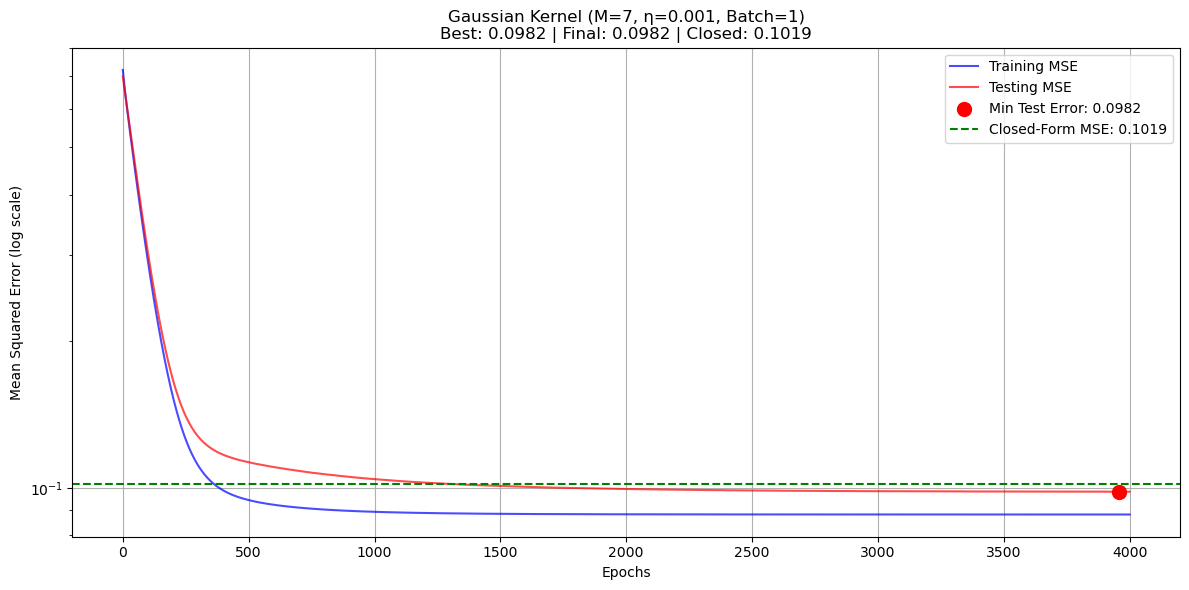


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.009483 |    -0.401825 |     0.392341
w1:     0.039752 |     0.373438 |     0.333686
w2:     0.891957 |     1.189828 |     0.297871
w3:     0.761530 |     1.069910 |     0.308380
w4:    -0.008965 |     0.296694 |     0.305659
w5:    -0.756992 |    -0.449339 |     0.307653
w6:    -0.889460 |    -0.591690 |     0.297770
w7:    -0.032075 |     0.305411 |     0.337486


In [8]:
# For gaussian kernel

w5_gaussian= training(X_train, Y_train, X_test, Y_test, 'gaussian', 5, 4000, 0.001, BatchSize=1)
w6_gaussian = training(X_train, Y_train,X_test,Y_test,'gaussian',6,4000,0.001,BatchSize=1)
w7_gaussian = training(X_train, Y_train,X_test,Y_test,'gaussian',7,4000,0.001,BatchSize=1)

Epoch 0/5000: Train MSE=0.7205, Test MSE=0.6989, |∇|=0.179378
Epoch 500/5000: Train MSE=0.2478, Test MSE=0.2540, |∇|=0.533043
Epoch 1000/5000: Train MSE=0.1833, Test MSE=0.2105, |∇|=0.000631
Epoch 1500/5000: Train MSE=0.1557, Test MSE=0.1916, |∇|=0.407467
Epoch 2000/5000: Train MSE=0.1428, Test MSE=0.1815, |∇|=0.282206
Epoch 2500/5000: Train MSE=0.1360, Test MSE=0.1754, |∇|=0.470031
Epoch 3000/5000: Train MSE=0.1318, Test MSE=0.1713, |∇|=0.389114
Epoch 3500/5000: Train MSE=0.1288, Test MSE=0.1678, |∇|=0.186403
Epoch 4000/5000: Train MSE=0.1265, Test MSE=0.1648, |∇|=0.106119
Epoch 4500/5000: Train MSE=0.1245, Test MSE=0.1621, |∇|=0.235866


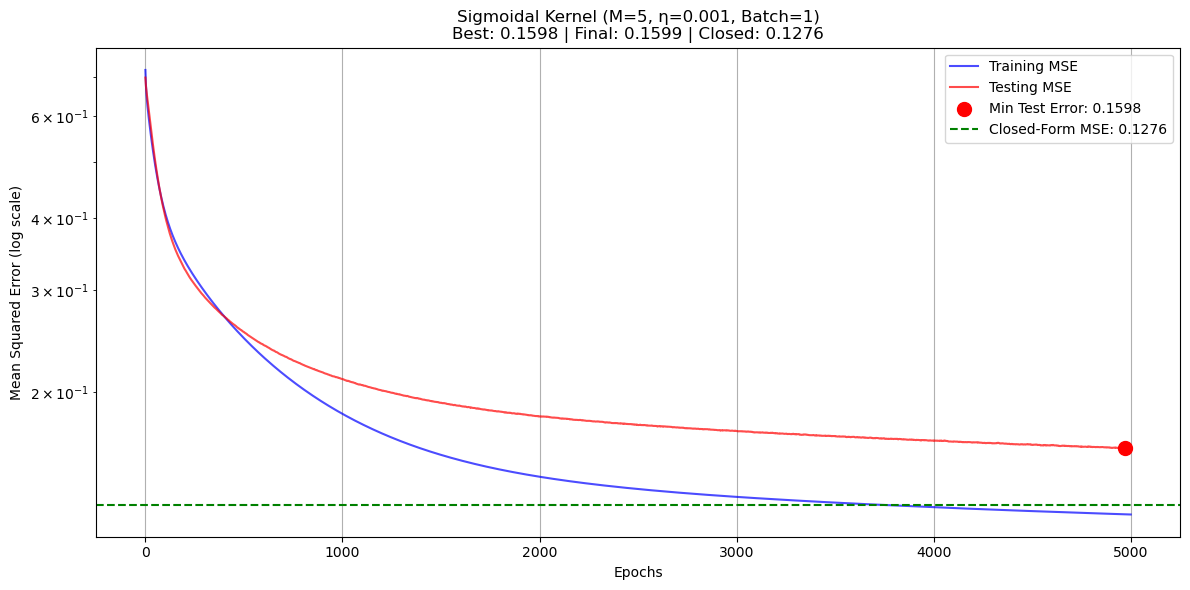


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.139440 |    -1.023310 |     0.883871
w1:     0.984151 |     2.135413 |     1.151262
w2:     0.136899 |    -0.216635 |     0.353533
w3:    -2.041947 |    -1.886467 |     0.155480
w4:     0.052713 |    -0.100227 |     0.152939
w5:     1.708888 |     1.958338 |     0.249450
Epoch 0/5000: Train MSE=0.7205, Test MSE=0.6989, |∇|=2.311101
Epoch 500/5000: Train MSE=0.2100, Test MSE=0.2137, |∇|=0.081054
Epoch 1000/5000: Train MSE=0.1469, Test MSE=0.1668, |∇|=0.004483
Epoch 1500/5000: Train MSE=0.1250, Test MSE=0.1490, |∇|=0.053838
Epoch 2000/5000: Train MSE=0.1170, Test MSE=0.1407, |∇|=0.047242
Epoch 2500/5000: Train MSE=0.1136, Test MSE=0.1367, |∇|=0.137658
Epoch 3000/5000: Train MSE=0.1116, Test MSE=0.1341, |∇|=0.411217
Epoch 3500/5000: Train MSE=0.1101, Test MSE=0.1320, |∇|=0.121134
Epoch 4000/5000: Train MSE=0.1089, Test MSE=0.1304, |∇|=0.011319
Epoch 4500/5000: Train MSE=0.1078

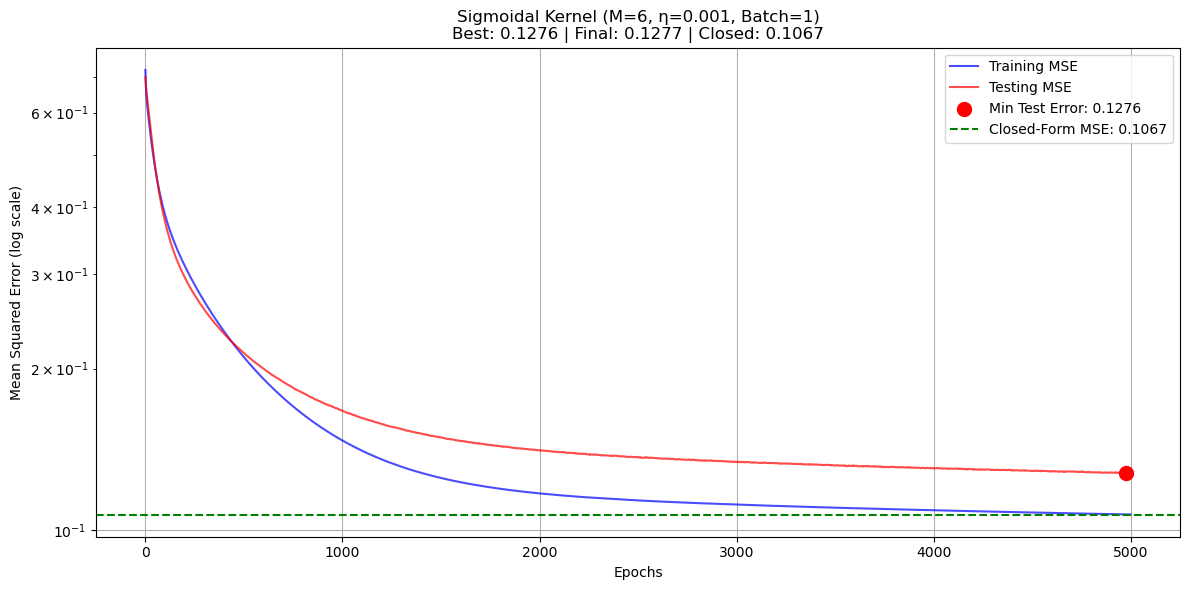


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.079963 |    -0.744219 |     0.664256
w1:     0.758188 |     1.671451 |     0.913263
w2:     0.614160 |     0.312762 |     0.301398
w3:    -1.272353 |    -1.239094 |     0.033259
w4:    -1.401996 |    -1.309965 |     0.092030
w5:     0.606150 |     0.411258 |     0.194891
w6:     1.222437 |     1.535768 |     0.313331
Epoch 0/5000: Train MSE=0.7205, Test MSE=0.6989, |∇|=0.667455
Epoch 500/5000: Train MSE=0.1801, Test MSE=0.1931, |∇|=0.375153
Epoch 1000/5000: Train MSE=0.1232, Test MSE=0.1524, |∇|=0.224839
Epoch 1500/5000: Train MSE=0.1071, Test MSE=0.1380, |∇|=0.320788
Epoch 2000/5000: Train MSE=0.1018, Test MSE=0.1313, |∇|=0.287844
Epoch 2500/5000: Train MSE=0.0993, Test MSE=0.1276, |∇|=0.103854
Epoch 3000/5000: Train MSE=0.0976, Test MSE=0.1249, |∇|=0.174102
Epoch 3500/5000: Train MSE=0.0962, Test MSE=0.1227, |∇|=0.311745
Epoch 4000/5000: Train MSE=0.0951, Test MSE=0.1208,

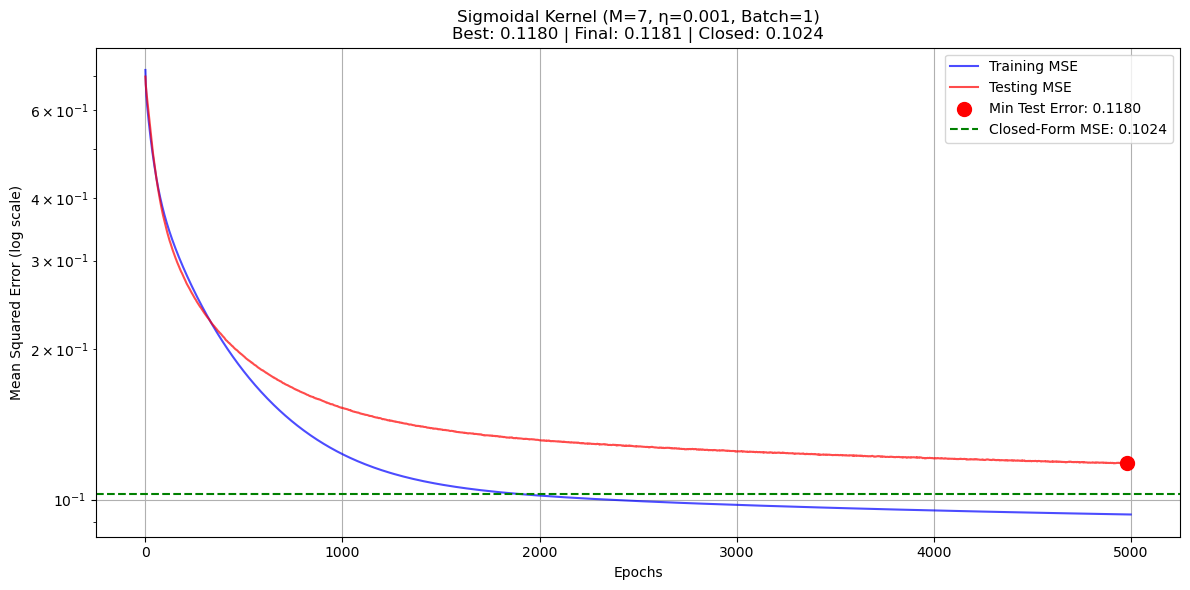


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:    -0.071062 |    -0.606765 |     0.535702
w1:     0.647263 |     1.400786 |     0.753522
w2:     0.753366 |     0.538157 |     0.215209
w3:    -0.682289 |    -0.737340 |     0.055051
w4:    -1.303745 |    -1.212391 |     0.091353
w5:    -0.791483 |    -0.803697 |     0.012213
w6:     0.833577 |     0.710636 |     0.122941
w7:     0.942582 |     1.176191 |     0.233609


In [9]:
#For sigmoidal kernel

w5_sigmoidal= training(X_train, Y_train, X_test, Y_test, 'sigmoidal', 5, 5000, 0.001, BatchSize=1)
w6_sigmoidal = training(X_train, Y_train,X_test,Y_test,'sigmoidal',6,5000,0.001,BatchSize=1)
w7_sigmoidal = training(X_train, Y_train,X_test,Y_test,'sigmoidal',7,5000,0.001,BatchSize=1)

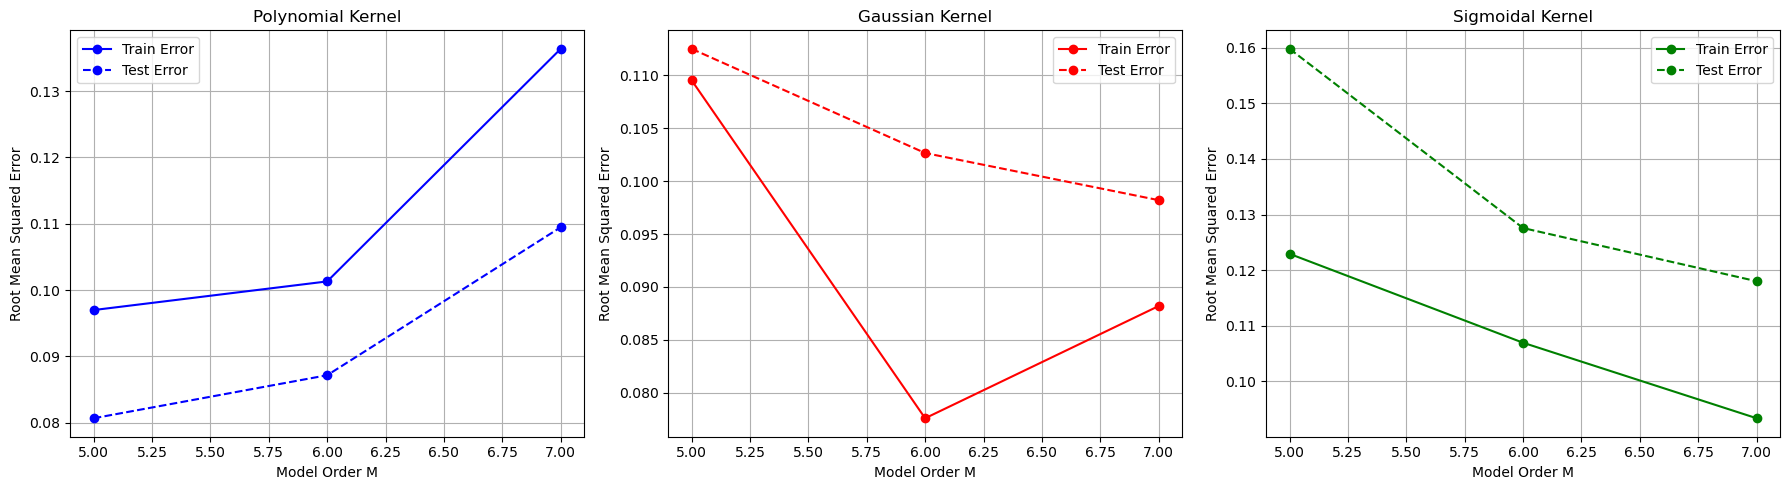

In [10]:
# Plotting tarining and test errors vs model order from the weights obtained through stochastic gradient descent

m_orders = [5, 6, 7]

poly_tr_error = []
poly_te_error = []
gauss_tr_error = []
gauss_te_error = []
sigm_tr_error = []
sigm_te_error = []


tr_err, te_err = KernelRegressionPred_Error(w5,X_train,Y_train,X_test,Y_test,'polynomial')
poly_tr_error.append(tr_err)
poly_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w6,X_train,Y_train,X_test,Y_test,'polynomial')
poly_tr_error.append(tr_err)
poly_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w7,X_train,Y_train,X_test,Y_test,'polynomial')
poly_tr_error.append(tr_err)
poly_te_error.append(te_err)


tr_err, te_err = KernelRegressionPred_Error(w5_gaussian,X_train,Y_train,X_test,Y_test,'gaussian')
gauss_tr_error.append(tr_err)
gauss_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w6_gaussian,X_train,Y_train,X_test,Y_test,'gaussian')
gauss_tr_error.append(tr_err)
gauss_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w7_gaussian,X_train,Y_train,X_test,Y_test,'gaussian')
gauss_tr_error.append(tr_err)
gauss_te_error.append(te_err)

tr_err, te_err = KernelRegressionPred_Error(w5_sigmoidal,X_train,Y_train,X_test,Y_test,'sigmoidal')
sigm_tr_error.append(tr_err)
sigm_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w6_sigmoidal,X_train,Y_train,X_test,Y_test,'sigmoidal')
sigm_tr_error.append(tr_err)
sigm_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w7_sigmoidal,X_train,Y_train,X_test,Y_test,'sigmoidal')
sigm_tr_error.append(tr_err)
sigm_te_error.append(te_err)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
kernels = ['Polynomial', 'Gaussian', 'Sigmoidal']
train_errors = [poly_tr_error, gauss_tr_error, sigm_tr_error]
test_errors  = [poly_te_error, gauss_te_error, sigm_te_error]
colors = ['blue', 'red', 'green']

for i in range(3):
    axs[i].plot(m_orders, train_errors[i], marker='o', color=colors[i], label='Train Error')
    axs[i].plot(m_orders, test_errors[i], marker='o', color=colors[i], linestyle='--', label='Test Error')
    axs[i].set_title(f"{kernels[i]} Kernel")
    axs[i].set_xlabel("Model Order M")
    axs[i].set_ylabel("Root Mean Squared Error")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

### Repeating for 3b

In [11]:
# Generating the dataset

x1 = np.random.uniform(0, 3, 100)
y1_true = np.zeros_like(x1)

mask1 = (x1 >= 0) & (x1 < 1)
mask2 = (x1 >= 1) & (x1 < 2)
mask3 = (x1 >= 2) & (x1 <= 3)

y1_true[mask1] = np.sin(2 * np.pi * x1[mask1])
y1_true[mask2] = 1 - 2 * np.abs(x1[mask2] - 1.5)
y1_true[mask3] = np.exp(-((x1[mask3] - 2.5) ** 2) / (2 * 0.1 ** 2))

y1 = y1_true + np.random.normal(0, 0.1, 100)

df1 = pd.DataFrame({'x1':x1, 'y1':y1})
train_df1 = df1.iloc[::2].reset_index(drop=True)
test_df1 = df1.iloc[1::2].reset_index(drop=True)
X_train1 = train_df1['x1']
Y_train1 = train_df1['y1']
X_test1 = test_df1['x1']
Y_test1 = test_df1['y1']

mean1 = np.mean(X_train1)
std_dev1 = np.std(X_train1)
X_train1 = (X_train1 - mean1) / std_dev1
X_test1 = (X_test1 - mean1) / std_dev1

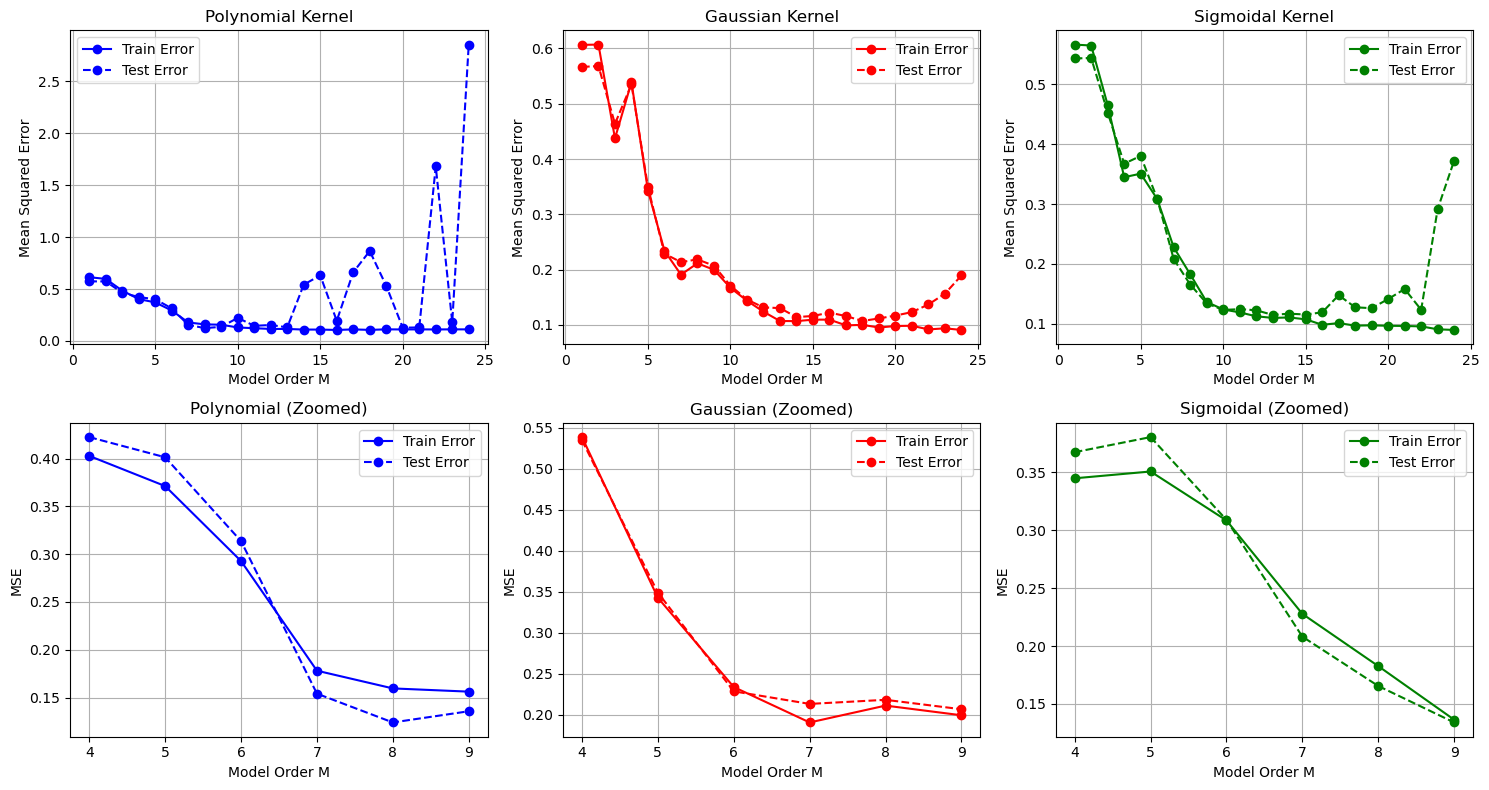

In [12]:
M_range=list(range(1,25))

polynomial_tr_error = []
polynomial_te_error = []
gaussian_tr_error = []
gaussian_te_error = []
sigmoid_tr_error = []
sigmoid_te_error = []

for m in  M_range:
  w_polynomial = closed_form_solution(X_train1,Y_train1,'polynomial',m,0)
  tr_err, te_err = KernelRegressionPred_Error(w_polynomial,X_train1,Y_train1,X_test1,Y_test1,'polynomial')
  polynomial_tr_error.append(tr_err)
  polynomial_te_error.append(te_err)

  w_gaussian = closed_form_solution(X_train1,Y_train1,'gaussian',m,0)
  tr_err, te_err = KernelRegressionPred_Error(w_gaussian,X_train1,Y_train1,X_test1,Y_test1,'gaussian')
  gaussian_tr_error.append(tr_err)
  gaussian_te_error.append(te_err)

  w_sigmoidal= closed_form_solution(X_train1,Y_train1,'sigmoidal',m,0)
  tr_err, te_err = KernelRegressionPred_Error(w_sigmoidal,X_train1,Y_train1,X_test1,Y_test1,'sigmoidal')
  sigmoid_tr_error.append(tr_err)
  sigmoid_te_error.append(te_err)


fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

# ---------- Full Range Plots (Row 0) ----------
# Polynomial
axes[0, 0].plot(M_range, polynomial_tr_error, 'b-o', label='Train Error')
axes[0, 0].plot(M_range, polynomial_te_error, 'b--o', label='Test Error')
axes[0, 0].set_title('Polynomial Kernel')
axes[0, 0].set_xlabel('Model Order M')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Gaussian
axes[0, 1].plot(M_range, gaussian_tr_error, 'r-o', label='Train Error')
axes[0, 1].plot(M_range, gaussian_te_error, 'r--o', label='Test Error')
axes[0, 1].set_title('Gaussian Kernel')
axes[0, 1].set_xlabel('Model Order M')
axes[0, 1].set_ylabel('Mean Squared Error')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Sigmoidal
axes[0, 2].plot(M_range, sigmoid_tr_error, 'g-o', label='Train Error')
axes[0, 2].plot(M_range, sigmoid_te_error, 'g--o', label='Test Error')
axes[0, 2].set_title('Sigmoidal Kernel')
axes[0, 2].set_xlabel('Model Order M')
axes[0, 2].set_ylabel('Mean Squared Error')
axes[0, 2].legend()
axes[0, 2].grid(True)

# ---------- Zoomed-In Plots (Row 1, M = 2 to 5) ----------
zoom_range = list(range(4, 10))  # M = 2 to 5
zoom_idx = [M_range.index(m) for m in zoom_range]

# Polynomial zoom
axes[1, 0].plot(zoom_range, [polynomial_tr_error[i] for i in zoom_idx], 'b-o', label='Train Error')
axes[1, 0].plot(zoom_range, [polynomial_te_error[i] for i in zoom_idx], 'b--o', label='Test Error')
axes[1, 0].set_title('Polynomial (Zoomed)')
axes[1, 0].set_xlabel('Model Order M')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Gaussian zoom
axes[1, 1].plot(zoom_range, [gaussian_tr_error[i] for i in zoom_idx], 'r-o', label='Train Error')
axes[1, 1].plot(zoom_range, [gaussian_te_error[i] for i in zoom_idx], 'r--o', label='Test Error')
axes[1, 1].set_title('Gaussian (Zoomed)')
axes[1, 1].set_xlabel('Model Order M')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Sigmoidal zoom
axes[1, 2].plot(zoom_range, [sigmoid_tr_error[i] for i in zoom_idx], 'g-o', label='Train Error')
axes[1, 2].plot(zoom_range, [sigmoid_te_error[i] for i in zoom_idx], 'g--o', label='Test Error')
axes[1, 2].set_title('Sigmoidal (Zoomed)')
axes[1, 2].set_xlabel('Model Order M')
axes[1, 2].set_ylabel('MSE')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

Epoch 0/5000: Train MSE=0.6464, Test MSE=0.5770, |∇|=1.314933
Epoch 500/5000: Train MSE=0.3806, Test MSE=0.3915, |∇|=2.418483
Epoch 1000/5000: Train MSE=0.3759, Test MSE=0.3946, |∇|=0.393446
Epoch 1500/5000: Train MSE=0.3771, Test MSE=0.3971, |∇|=0.328415
Epoch 2000/5000: Train MSE=0.3725, Test MSE=0.3979, |∇|=0.263815
Epoch 2500/5000: Train MSE=0.3721, Test MSE=0.3996, |∇|=0.777050
Epoch 3000/5000: Train MSE=0.3715, Test MSE=0.4013, |∇|=0.295476
Epoch 3500/5000: Train MSE=0.3745, Test MSE=0.3978, |∇|=1.067208
Epoch 4000/5000: Train MSE=0.3714, Test MSE=0.4002, |∇|=0.267677
Epoch 4500/5000: Train MSE=0.3727, Test MSE=0.4050, |∇|=1.565421


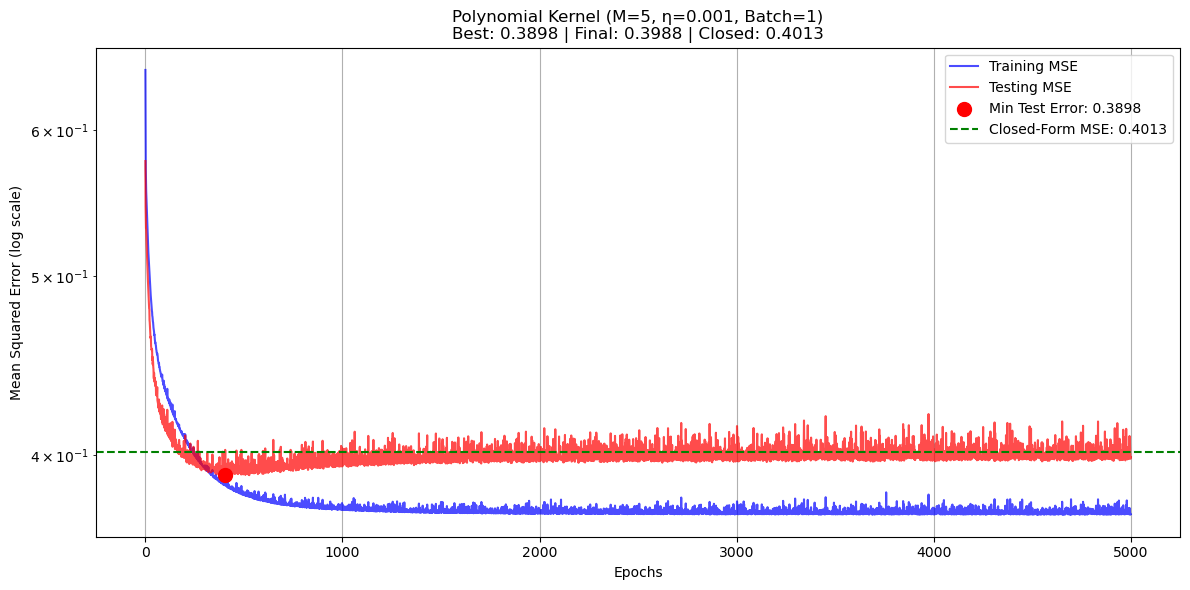


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.188990 |     0.365518 |     0.176528
w1:     0.550692 |     0.470169 |     0.080524
w2:    -0.628922 |    -1.076390 |     0.447468
w3:     0.056941 |     0.238595 |     0.181653
w4:     0.362897 |     0.531485 |     0.168588
w5:    -0.169243 |    -0.233859 |     0.064616
Epoch 0/5000: Train MSE=0.6464, Test MSE=0.5770, |∇|=0.383243
Epoch 500/5000: Train MSE=0.3913, Test MSE=0.4060, |∇|=2.972562
Epoch 1000/5000: Train MSE=0.3745, Test MSE=0.3782, |∇|=0.663249
Epoch 1500/5000: Train MSE=0.4389, Test MSE=0.4408, |∇|=14.347907
Epoch 2000/5000: Train MSE=0.3276, Test MSE=0.3544, |∇|=0.532351
Epoch 2500/5000: Train MSE=0.3170, Test MSE=0.3296, |∇|=0.587532
Epoch 3000/5000: Train MSE=0.3674, Test MSE=0.3684, |∇|=6.992253
Epoch 3500/5000: Train MSE=0.3531, Test MSE=0.4306, |∇|=0.070656
Epoch 4000/5000: Train MSE=0.4787, Test MSE=0.6211, |∇|=0.533981
Epoch 4500/5000: Train MSE=0.321

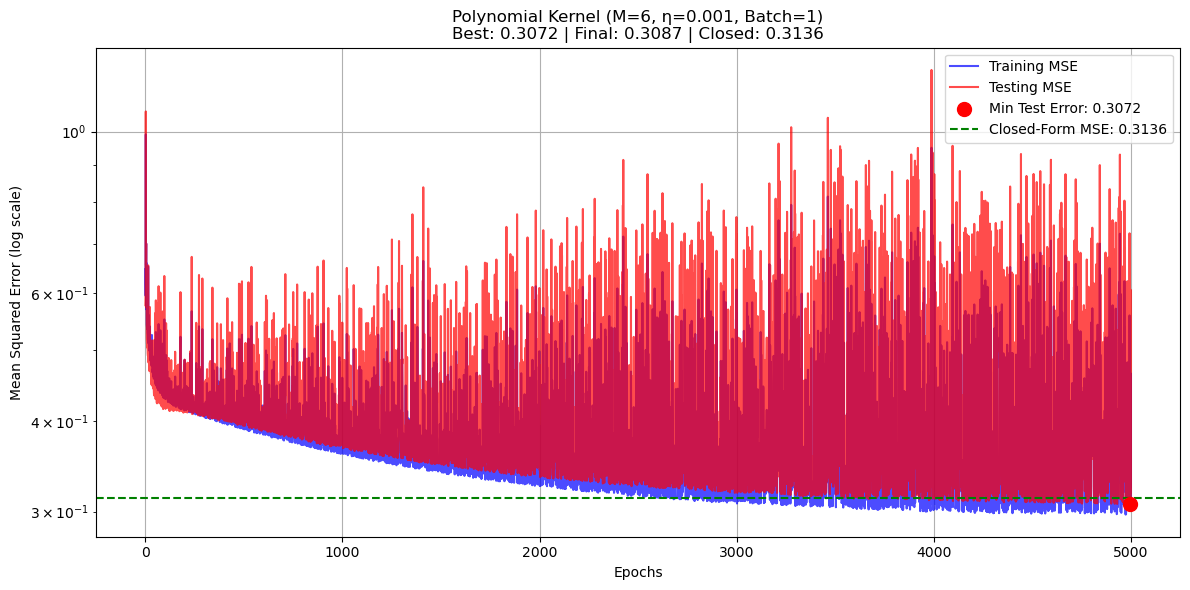


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.530920 |     0.600398 |     0.069479
w1:     0.834091 |     0.890195 |     0.056104
w2:    -2.258497 |    -2.603542 |     0.345045
w3:    -0.549797 |    -0.649285 |     0.099488
w4:     1.758142 |     2.062080 |     0.303938
w5:     0.052236 |     0.097052 |     0.044816
w6:    -0.315239 |    -0.380154 |     0.064915
Epoch 0/5000: Train MSE=0.6464, Test MSE=0.5770, |∇|=0.457157
Epoch 500/5000: Train MSE=0.4553, Test MSE=0.4405, |∇|=7.842157
Epoch 1000/5000: Train MSE=0.4341, Test MSE=0.4302, |∇|=6.621371
Epoch 1500/5000: Train MSE=0.4236, Test MSE=0.4237, |∇|=0.231613
Epoch 2000/5000: Train MSE=0.4187, Test MSE=0.4263, |∇|=1.359377
Epoch 2500/5000: Train MSE=0.4113, Test MSE=0.4150, |∇|=0.255962
Epoch 3000/5000: Train MSE=0.4060, Test MSE=0.4123, |∇|=0.401106
Epoch 3500/5000: Train MSE=0.4016, Test MSE=0.4086, |∇|=0.005710
Epoch 4000/5000: Train MSE=0.3969, Test MSE=0.4027,

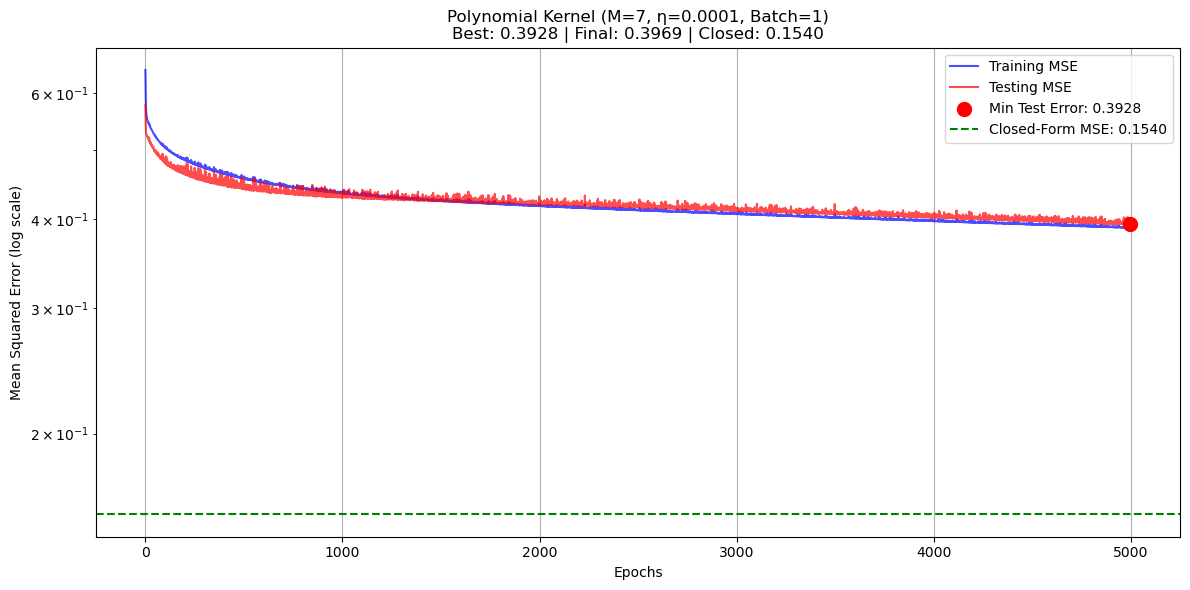


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.180729 |     0.818074 |     0.637345
w1:     0.560573 |    -0.011835 |     0.572408
w2:    -0.556401 |    -3.837457 |     3.281055
w3:     0.110403 |     1.946322 |     1.835919
w4:     0.327451 |     3.471314 |     3.143863
w5:    -0.230603 |    -1.811775 |     1.581172
w6:     0.000680 |    -0.783484 |     0.784164
w7:     0.015691 |     0.404201 |     0.388510


In [13]:
#For polynomial kernel

w5= training(X_train1, Y_train1, X_test1, Y_test1, 'polynomial', 5, 5000, 0.001, BatchSize=1)
w6 = training(X_train1, Y_train1,X_test1,Y_test1,'polynomial',6,5000,0.001,BatchSize=1)
w7 = training(X_train1, Y_train1,X_test1,Y_test1,'polynomial',7,5000,0.0001,BatchSize=1)

Epoch 0/5000: Train MSE=0.6464, Test MSE=0.5770, |∇|=1.231179
Epoch 500/5000: Train MSE=0.3497, Test MSE=0.3404, |∇|=0.884932
Epoch 1000/5000: Train MSE=0.3460, Test MSE=0.3386, |∇|=0.747483
Epoch 1500/5000: Train MSE=0.3459, Test MSE=0.3394, |∇|=0.049163
Epoch 2000/5000: Train MSE=0.3459, Test MSE=0.3398, |∇|=0.060670
Epoch 2500/5000: Train MSE=0.3458, Test MSE=0.3399, |∇|=0.316753
Epoch 3000/5000: Train MSE=0.3458, Test MSE=0.3400, |∇|=0.669432
Epoch 3500/5000: Train MSE=0.3458, Test MSE=0.3400, |∇|=0.411676
Epoch 4000/5000: Train MSE=0.3458, Test MSE=0.3400, |∇|=0.158781
Epoch 4500/5000: Train MSE=0.3458, Test MSE=0.3401, |∇|=0.243940


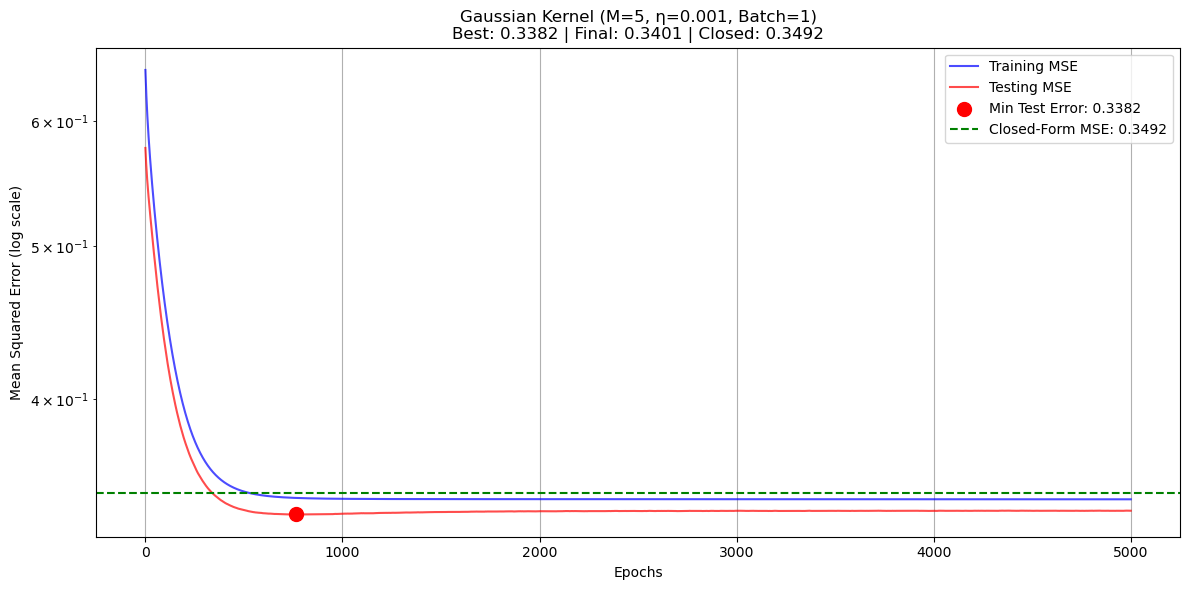


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.254092 |     2.478942 |     2.224851
w1:     0.835119 |    -1.158487 |     1.993605
w2:    -1.171308 |    -3.133352 |     1.962044
w3:     0.503620 |    -1.462983 |     1.966603
w4:    -0.140708 |    -2.095704 |     1.954996
w5:     0.160597 |    -1.845203 |     2.005799
Epoch 0/5000: Train MSE=0.6464, Test MSE=0.5770, |∇|=0.897043
Epoch 500/5000: Train MSE=0.2484, Test MSE=0.2548, |∇|=0.555420
Epoch 1000/5000: Train MSE=0.2374, Test MSE=0.2406, |∇|=0.301580
Epoch 1500/5000: Train MSE=0.2370, Test MSE=0.2383, |∇|=0.291504
Epoch 2000/5000: Train MSE=0.2370, Test MSE=0.2375, |∇|=0.040053
Epoch 2500/5000: Train MSE=0.2370, Test MSE=0.2372, |∇|=0.358015
Epoch 3000/5000: Train MSE=0.2370, Test MSE=0.2370, |∇|=0.158615
Epoch 3500/5000: Train MSE=0.2369, Test MSE=0.2369, |∇|=0.179856
Epoch 4000/5000: Train MSE=0.2369, Test MSE=0.2369, |∇|=0.222468
Epoch 4500/5000: Train MSE=0.2369

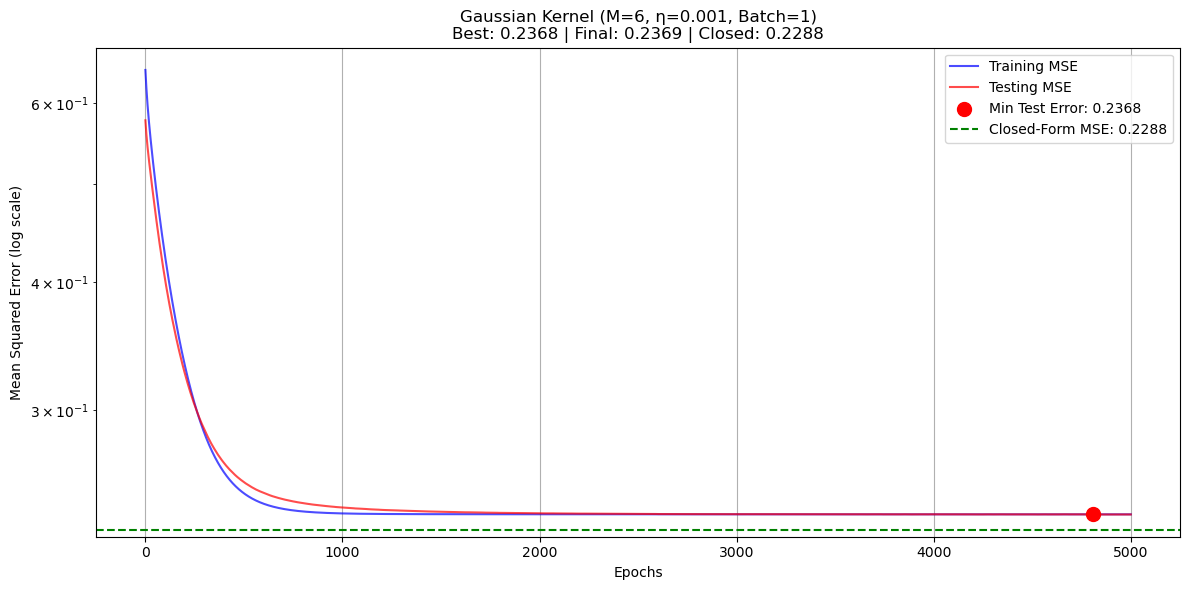


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.243389 |    -2.118128 |     2.361517
w1:     1.154292 |     3.251987 |     2.097695
w2:    -1.384981 |     0.567088 |     1.952069
w3:     0.552545 |     2.553998 |     2.001452
w4:    -0.037641 |     1.945885 |     1.983526
w5:     0.143167 |     2.113944 |     1.970777
w6:    -0.060096 |     2.073637 |     2.133734
Epoch 0/5000: Train MSE=0.6464, Test MSE=0.5770, |∇|=1.109474
Epoch 500/5000: Train MSE=0.2320, Test MSE=0.2426, |∇|=0.151850
Epoch 1000/5000: Train MSE=0.2134, Test MSE=0.2254, |∇|=0.217126
Epoch 1500/5000: Train MSE=0.2113, Test MSE=0.2216, |∇|=0.076711
Epoch 2000/5000: Train MSE=0.2107, Test MSE=0.2200, |∇|=0.110385
Epoch 2500/5000: Train MSE=0.2106, Test MSE=0.2192, |∇|=0.276374
Epoch 3000/5000: Train MSE=0.2105, Test MSE=0.2189, |∇|=0.000506
Epoch 3500/5000: Train MSE=0.2105, Test MSE=0.2187, |∇|=0.546600
Epoch 4000/5000: Train MSE=0.2105, Test MSE=0.2186,

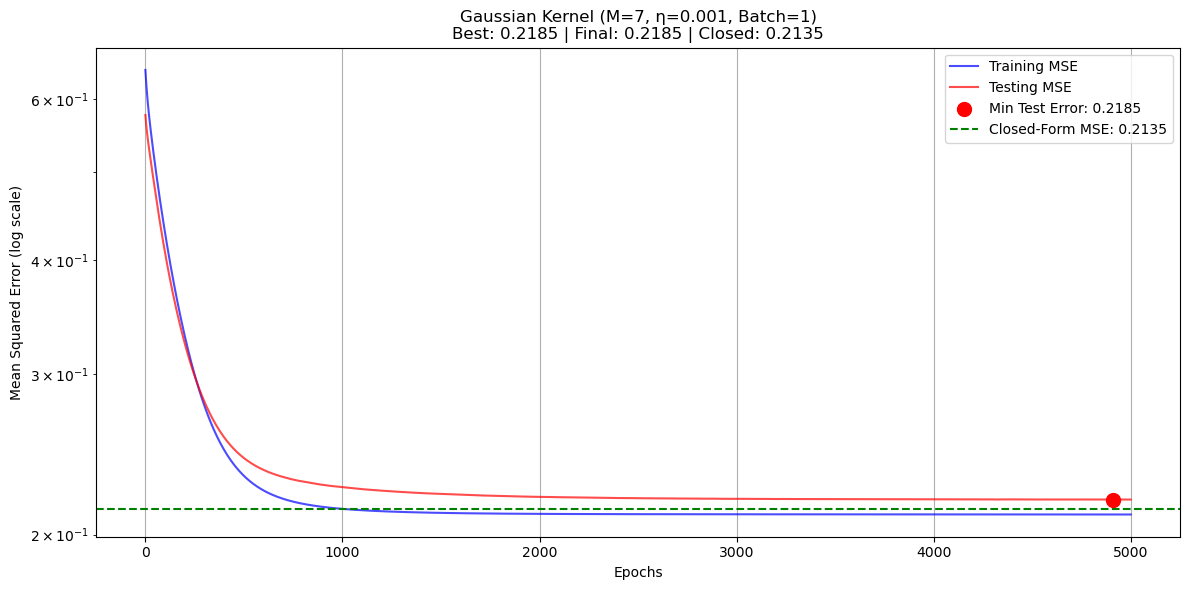


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     0.182127 |    -7.040494 |     7.222621
w1:     1.293324 |     7.573842 |     6.280517
w2:    -1.203106 |     4.655550 |     5.858657
w3:    -0.076873 |     5.865545 |     5.942418
w4:     0.709828 |     6.642015 |     5.932187
w5:    -0.429022 |     5.579513 |     6.008536
w6:     0.551333 |     6.386508 |     5.835175
w7:    -0.344166 |     6.092732 |     6.436898


In [14]:
#For gaussian kernel

w5_gaussian= training(X_train1, Y_train1, X_test1, Y_test1, 'gaussian', 5, 5000, 0.001, BatchSize=1)
w6_gaussian = training(X_train1, Y_train1,X_test1,Y_test1,'gaussian',6,5000,0.001,BatchSize=1)
w7_gaussian = training(X_train1, Y_train1,X_test1,Y_test1,'gaussian',7,5000,0.001,BatchSize=1)

Epoch 0/1000: Train MSE=0.6464, Test MSE=0.5770, |∇|=0.056898
Epoch 100/1000: Train MSE=0.5409, Test MSE=0.5111, |∇|=0.460291
Epoch 200/1000: Train MSE=0.4978, Test MSE=0.4695, |∇|=0.727433
Epoch 300/1000: Train MSE=0.4636, Test MSE=0.4445, |∇|=1.097709
Epoch 400/1000: Train MSE=0.4367, Test MSE=0.4272, |∇|=0.670937
Epoch 500/1000: Train MSE=0.4161, Test MSE=0.4139, |∇|=0.138895
Epoch 600/1000: Train MSE=0.4002, Test MSE=0.4030, |∇|=1.052935
Epoch 700/1000: Train MSE=0.3880, Test MSE=0.3948, |∇|=0.106869
Epoch 800/1000: Train MSE=0.3791, Test MSE=0.3846, |∇|=0.339440
Epoch 900/1000: Train MSE=0.3721, Test MSE=0.3876, |∇|=0.267803


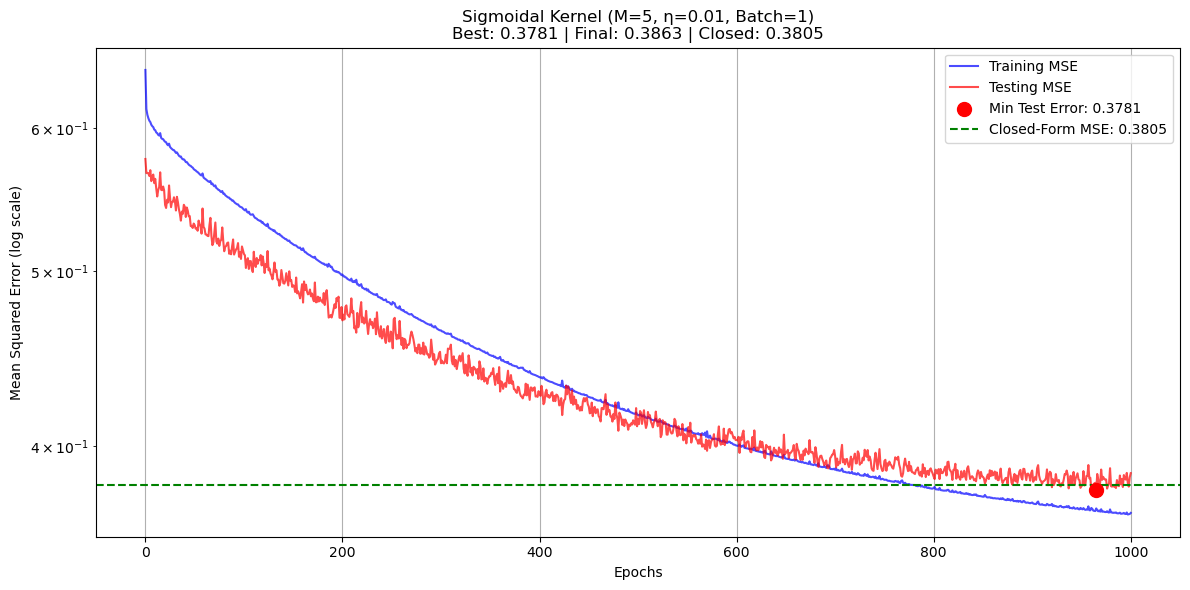


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     4.000265 |     5.156942 |     1.156678
w1:    -5.152801 |    -6.652361 |     1.499559
w2:     1.484513 |     2.055700 |     0.571187
w3:    -0.075610 |    -0.347155 |     0.271546
w4:     0.168883 |     0.336162 |     0.167279
w5:    -0.699816 |    -1.080100 |     0.380284
Epoch 0/4000: Train MSE=0.6464, Test MSE=0.5770, |∇|=0.082148
Epoch 400/4000: Train MSE=0.3822, Test MSE=0.3550, |∇|=0.665814
Epoch 800/4000: Train MSE=0.3437, Test MSE=0.3240, |∇|=0.472618
Epoch 1200/4000: Train MSE=0.3263, Test MSE=0.3105, |∇|=0.392580
Epoch 1600/4000: Train MSE=0.3176, Test MSE=0.3059, |∇|=0.014384
Epoch 2000/4000: Train MSE=0.3130, Test MSE=0.3035, |∇|=0.261059
Epoch 2400/4000: Train MSE=0.3109, Test MSE=0.3047, |∇|=0.297921
Epoch 2800/4000: Train MSE=0.3097, Test MSE=0.3051, |∇|=0.175716
Epoch 3200/4000: Train MSE=0.3096, Test MSE=0.3053, |∇|=0.215195
Epoch 3600/4000: Train MSE=0.3088,

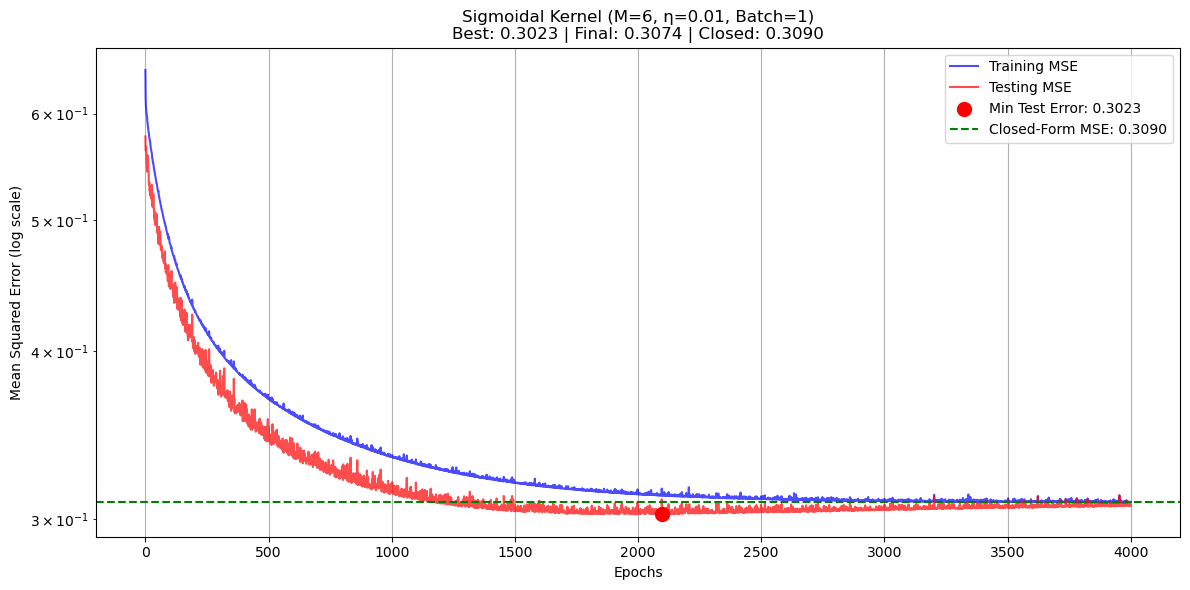


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     3.819064 |     4.352810 |     0.533746
w1:    -4.619140 |    -5.384482 |     0.765342
w2:    -0.004819 |     0.361256 |     0.366075
w3:     2.159832 |     2.030378 |     0.129454
w4:    -1.961941 |    -1.983802 |     0.021861
w5:     1.862127 |     2.048162 |     0.186035
w6:    -2.633834 |    -3.177100 |     0.543266
Epoch 0/4000: Train MSE=0.6464, Test MSE=0.5770, |∇|=1.355744
Epoch 400/4000: Train MSE=0.2835, Test MSE=0.2748, |∇|=0.430000
Epoch 800/4000: Train MSE=0.2433, Test MSE=0.2322, |∇|=0.516674
Epoch 1200/4000: Train MSE=0.2377, Test MSE=0.2176, |∇|=0.480811
Epoch 1600/4000: Train MSE=0.2312, Test MSE=0.2161, |∇|=0.367857
Epoch 2000/4000: Train MSE=0.2313, Test MSE=0.2110, |∇|=0.093013
Epoch 2400/4000: Train MSE=0.2292, Test MSE=0.2126, |∇|=0.560202
Epoch 2800/4000: Train MSE=0.2293, Test MSE=0.2089, |∇|=0.137086
Epoch 3200/4000: Train MSE=0.2291, Test MSE=0.2134, 

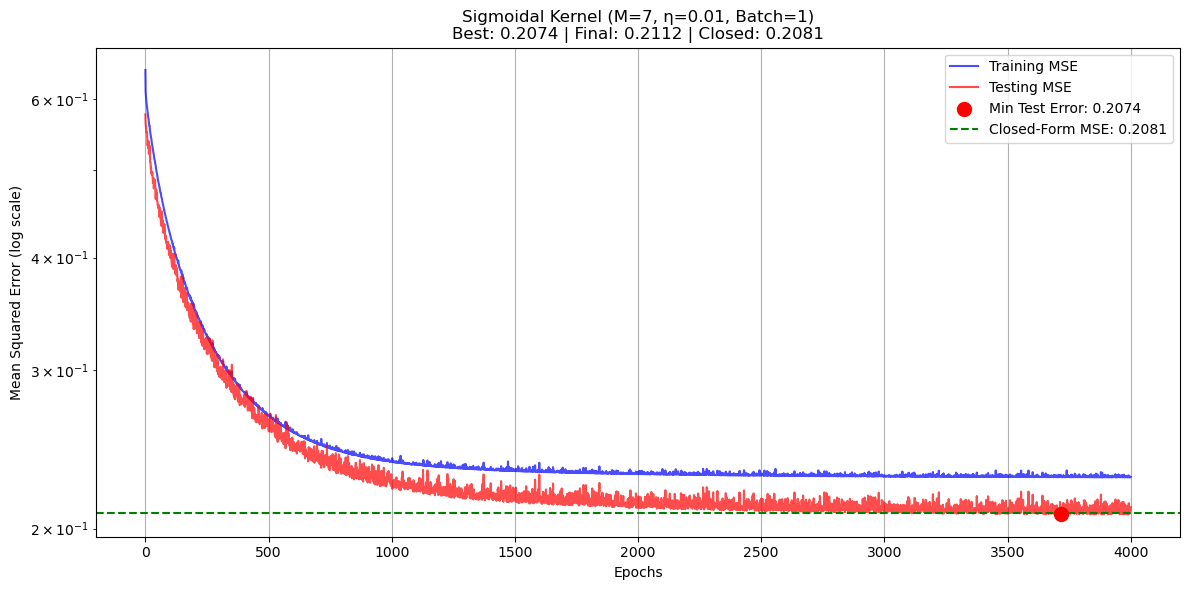


Weight Comparison:
                SGD Weights               Closed-Form Weights       Difference     
w0:     2.095069 |     1.986224 |     0.108845
w1:    -1.431153 |    -1.240181 |     0.190972
w2:    -3.027560 |    -3.128744 |     0.101184
w3:     4.397008 |     4.448694 |     0.051686
w4:    -2.101186 |    -2.090348 |     0.010838
w5:     0.017344 |    -0.043760 |     0.061104
w6:     1.229664 |     1.390996 |     0.161333
w7:    -2.504939 |    -2.815883 |     0.310944


In [15]:
#For sigmoidal kernel

w5_sigmoidal= training(X_train1, Y_train1, X_test1, Y_test1, 'sigmoidal', 5, 1000, 0.01, BatchSize=1)
w6_sigmoidal = training(X_train1, Y_train1,X_test1,Y_test1,'sigmoidal',6,4000,0.01,BatchSize=1)
w7_sigmoidal = training(X_train1, Y_train1,X_test1,Y_test1,'sigmoidal',7,4000,0.01,BatchSize=1)

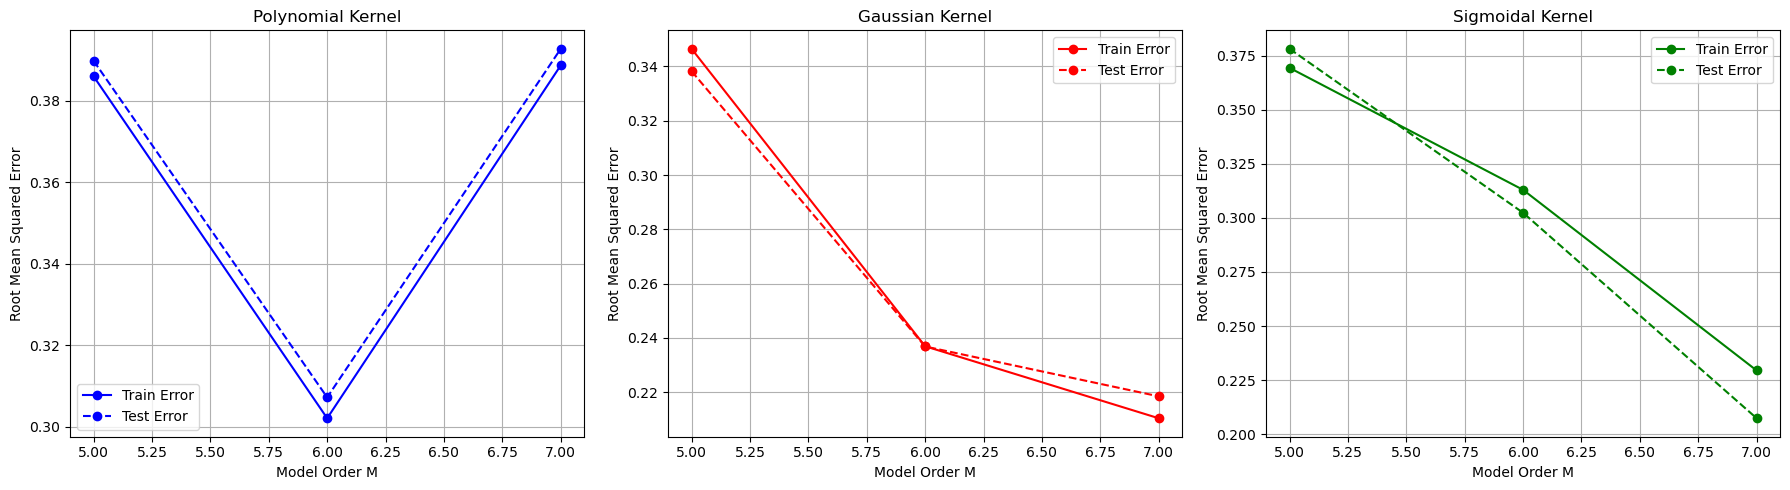

In [16]:
m_orders = [5, 6, 7]

poly_tr_error = []
poly_te_error = []
gauss_tr_error = []
gauss_te_error = []
sigm_tr_error = []
sigm_te_error = []


tr_err, te_err = KernelRegressionPred_Error(w5,X_train1,Y_train1,X_test1,Y_test1,'polynomial')
poly_tr_error.append(tr_err)
poly_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w6,X_train1,Y_train1,X_test1,Y_test1,'polynomial')
poly_tr_error.append(tr_err)
poly_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w7,X_train1,Y_train1,X_test1,Y_test1,'polynomial')
poly_tr_error.append(tr_err)
poly_te_error.append(te_err)


tr_err, te_err = KernelRegressionPred_Error(w5_gaussian,X_train1,Y_train1,X_test1,Y_test1,'gaussian')
gauss_tr_error.append(tr_err)
gauss_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w6_gaussian,X_train1,Y_train1,X_test1,Y_test1,'gaussian')
gauss_tr_error.append(tr_err)
gauss_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w7_gaussian,X_train1,Y_train1,X_test1,Y_test1,'gaussian')
gauss_tr_error.append(tr_err)
gauss_te_error.append(te_err)

tr_err, te_err = KernelRegressionPred_Error(w5_sigmoidal,X_train1,Y_train1,X_test1,Y_test1,'sigmoidal')
sigm_tr_error.append(tr_err)
sigm_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w6_sigmoidal,X_train1,Y_train1,X_test1,Y_test1,'sigmoidal')
sigm_tr_error.append(tr_err)
sigm_te_error.append(te_err)
tr_err, te_err = KernelRegressionPred_Error(w7_sigmoidal,X_train1,Y_train1,X_test1,Y_test1,'sigmoidal')
sigm_tr_error.append(tr_err)
sigm_te_error.append(te_err)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
kernels = ['Polynomial', 'Gaussian', 'Sigmoidal']
train_errors = [poly_tr_error, gauss_tr_error, sigm_tr_error]
test_errors  = [poly_te_error, gauss_te_error, sigm_te_error]
colors = ['blue', 'red', 'green']

for i in range(3):
    axs[i].plot(m_orders, train_errors[i], marker='o', color=colors[i], label='Train Error')
    axs[i].plot(m_orders, test_errors[i], marker='o', color=colors[i], linestyle='--', label='Test Error')
    axs[i].set_title(f"{kernels[i]} Kernel")
    axs[i].set_xlabel("Model Order M")
    axs[i].set_ylabel("Root Mean Squared Error")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


Training with step size: 0.0005

Training with step size: 0.0001

Training with step size: 0.001

Training with step size: 0.01


C:\Users\SAANVI GOEL\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\SAANVI GOEL\AppData\Local\Temp\ipykernel_6916\662387695.py:47: RuntimeWarning: overflow encountered in multiply
  gradient += error * X_tr
C:\Users\SAANVI GOEL\AppData\Local\Temp\ipykernel_6916\662387695.py:50: RuntimeWarning: invalid value encountered in subtract
  weights -= stepSize * gradient_avg


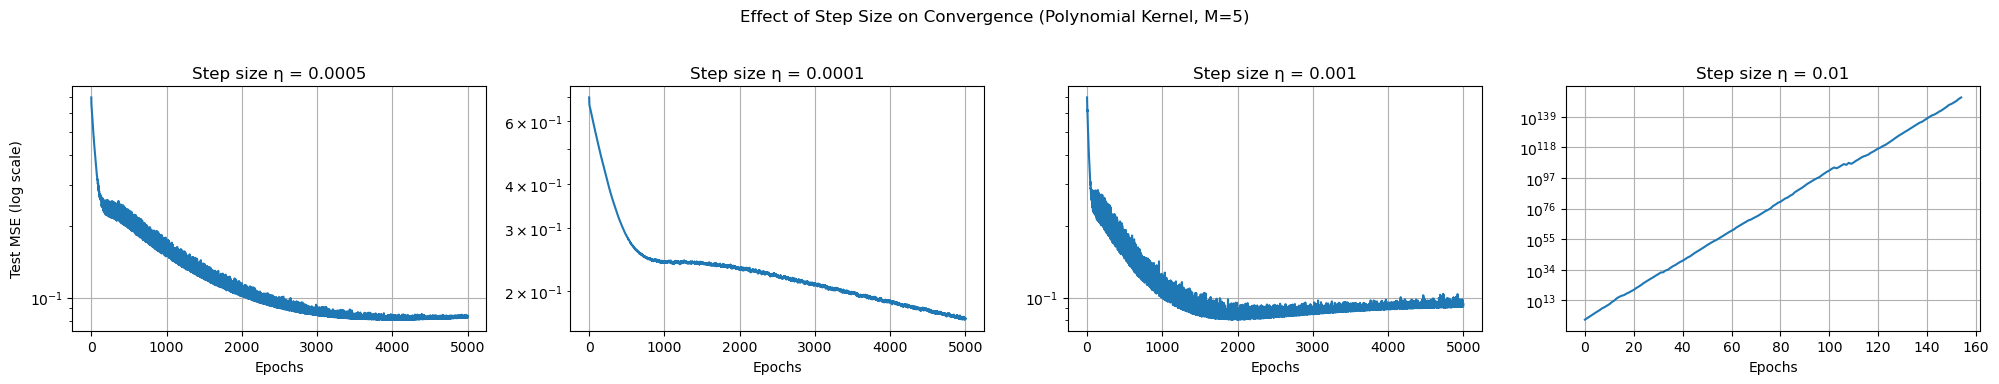

In [17]:
#Now, to study the effect of step size on convergence of weights, we will focus on a fixed kernel, let that be 'polynomial' and a fixed M = 5 and fixed batchsize = 1. We will vary the stepSize

step_sizes = [0.0005, 0.0001, 0.001,0.01]
all_test_errors = {}

for step in step_sizes:
  print(f"\nTraining with step size: {step}")
  _, _, test_err = training(X_train,Y_train,X_test,Y_test,'polynomial',M=5, epochs = 5000 ,stepSize=step,BatchSize=1,print_epochs=False,plot_=False,return_err=True)
  all_test_errors[step] = test_err

fig, axs = plt.subplots(1, len(step_sizes), figsize=(20, 4))

for i, step in enumerate(step_sizes):
    axs[i].semilogy(all_test_errors[step], color='tab:blue')
    axs[i].set_title(f"Step size η = {step}")
    axs[i].set_xlabel("Epochs")
    if i == 0:
        axs[i].set_ylabel("Test MSE (log scale)")
    axs[i].grid(True)

plt.suptitle("Effect of Step Size on Convergence (Polynomial Kernel, M=5)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The plot effectively demonstrates the impact of different step sizes (learning rates) on the convergence behavior of weights in stochastic gradient descent. With very small step sizes like η = 0.0005 and η = 0.0001, the mean squared error (MSE) decreases gradually and smoothly over epochs, indicating stable and consistent convergence. A slightly larger step size, η = 0.001, shows faster initial error reduction but introduces significant fluctuations, suggesting instability and overshooting due to larger update steps. At η = 0.01, the training completely diverges, with the error increasing exponentially—highlighting that too large a step size leads to unstable updates and failure to converge. Overall, the plots clearly show that while a small learning rate ensures stability, an appropriately chosen moderate learning rate (like 0.0001) achieves a good balance between speed and stability, whereas a large step size results in divergence and ineffective training.


Training with batch size: 1

Training with batch size: 4

Training with batch size: 8

Training with batch size: 16

Training with batch size: 32

Training with batch size: 50


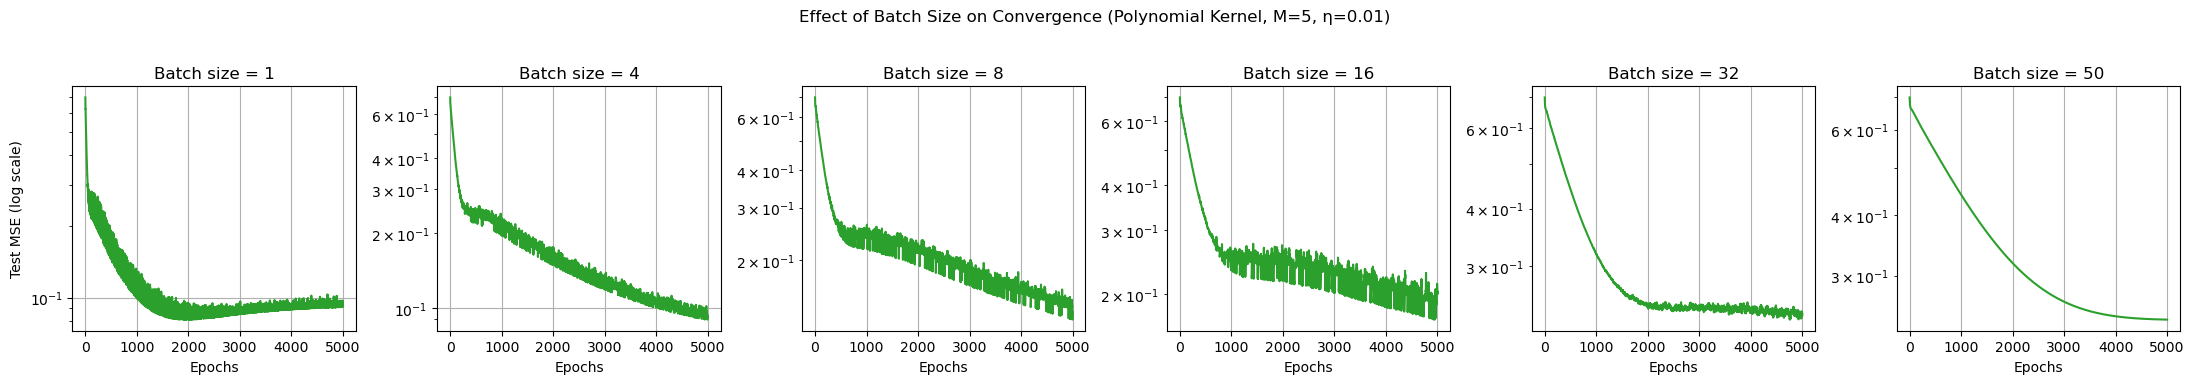

In [18]:
# Now, to study the effect of batch size on weights, we will focus on a fixed kernel, let that be 'polynomial' and a fixed M = 5 and fixed stepsize=0.001 . We will vary the batchSize

batch_sizes = [1, 4, 8, 16, 32, 50]
all_errors = {}

for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")
    _, _, test_err = training(X_train, Y_train, X_test, Y_test,
                              'polynomial',
                              M=5,
                              epochs=5000,
                              stepSize=0.001,
                              BatchSize=bs,
                              print_epochs=False,
                              plot_=False,
                              return_err=True)
    all_errors[bs] = test_err

# Plotting
fig, axs = plt.subplots(1, len(batch_sizes), figsize=(22, 4))

for i, bs in enumerate(batch_sizes):
    axs[i].semilogy(all_errors[bs], color='tab:green')
    axs[i].set_title(f"Batch size = {bs}")
    axs[i].set_xlabel("Epochs")
    if i == 0:
        axs[i].set_ylabel("Test MSE (log scale)")
    axs[i].grid(True)

plt.suptitle("Effect of Batch Size on Convergence (Polynomial Kernel, M=5, η=0.01)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

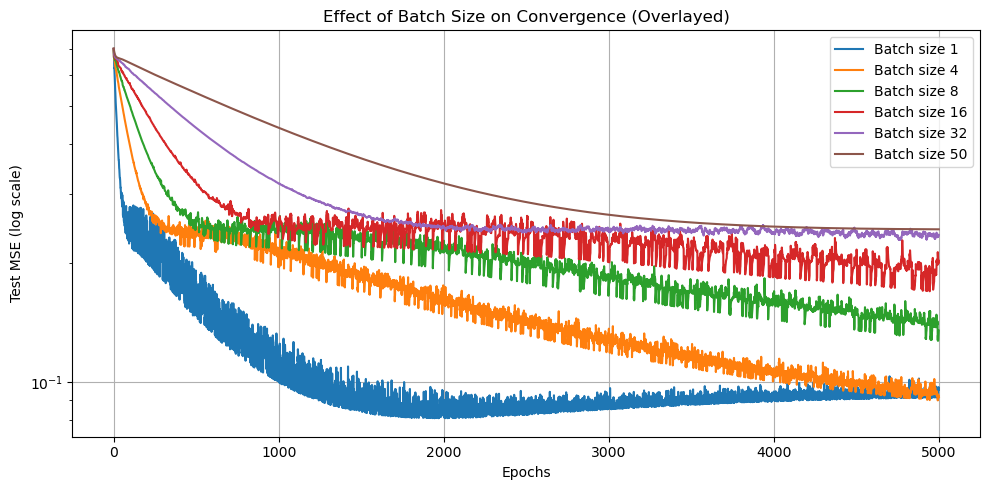

In [19]:
plt.figure(figsize=(10, 5))
for bs in batch_sizes:
    plt.semilogy(all_errors[bs], label=f'Batch size {bs}')
plt.xlabel("Epochs")
plt.ylabel("Test MSE (log scale)")
plt.title("Effect of Batch Size on Convergence (Overlayed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The plots illustrate the effect of batch size on the convergence behavior. It is evident that smaller batch sizes, particularly batch size 1 (stochastic gradient descent), lead to faster initial convergence due to more frequent weight updates, although the updates are noisier. As the batch size increases, the convergence becomes smoother but slower, with batch sizes like 32 and 50 showing noticeably delayed error reduction over the same number of epochs. This highlights the classic trade-off between the speed and stability of convergence in gradient-based optimization — smaller batches improve responsiveness, while larger batches improve gradient accuracy but require more epochs to achieve similar performance.

**OBSERVATIONS**

1. Convergence of weights to closed form solutions depend on the model complexity. More complex models require slower learning rate and hence, more number of iterations.

2. Small step sizes lead to stable and gradual convergence, while moderately larger step sizes accelerate learning but may introduce fluctuations. Extremely large step sizes result in instability and divergence. Overall, a balanced step size ensures efficient and reliable training in stochastic gradient descent.

3. Smaller batch sizes lead to quicker but noisier convergence due to more frequent updates, while larger batch sizes result in slower yet smoother and more stable convergence. This reflects the classic trade-off: small batches offer responsiveness, large batches offer accuracy.









Method to choose efficient stepSize and batchSize

We can create a matrix with the rows as stepSize and the columns as BatchSize. For each cell in the matrix, we can run the model for a fixed number of epochs, and test its accuracy. We can chose the cell with the highest accuracy.

If during training, gradients or errors become extremely large (a sign of divergence or instability), gradient clipping can be applied.This technique sets a maximum threshold for gradient values.It helps prevent exploding gradients, especially in models using SGD or mini-batch SGD.